In [2]:
from scipy.io import netcdf
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from netCDF4 import Dataset

from IPython.display import display, Math, Latex, Image
from mpl_toolkits.basemap import Basemap
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append('/noc/users/am8e13/PyNGL-1.4.0/lib/python2.7/site-packages/PyNGL/')
import Ngl
sys.path.append('/noc/users/am8e13/Python/')
import komod
sys.path.append('/noc/users/am8e13/Python/PyNIO-1.4.0/')
import Nio

sys.path.append('/noc/users/am8e13/Python/')
from python_functions import *
import cmocean
import random
import calendar

from IPython.html.widgets import interact, interactive
from IPython.display import clear_output, display, HTML

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
woa = Woa()
#grid = grid_read(36)
grid = grid_read(18)

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [5]:
times = range(0,60,1)+range(61,61+60,1)+range(122,122+60,1)
pert_bench = RunRead()
pert_bench.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/')
pert_bench.title('No restoring','blue')
pert_bench.readStateData(times)
pert_bench.readMonitorData([6220800,6480000,6739200])
pert_bench.readMonitorSeaiceData([6220800,6480000,6739200])
pert_bench.readDynStData(11,[6220800,6480000,6739200])
#pert_bench.readTracers(range(0,75,12))
#pert_bench.readLayers(range(0,75,12))
#pert_bench.seaiceread(range(0,75,1))
pert_bench.mxldepthread(range(0,180*3,1))
pert_bench.fluxCalc()
pert_bench.baroCalc()
pert_bench.saveflux('exp_benchmark')
pert_bench.savepsi('exp_benchmark')
#pert_bench.read_flux('exp_benchmark')
#pert_bench.read_psi('exp_benchmark')
#pert_bench.readDynStDiagLayers([6220800,6480000])
#pert_bench.readDynStDiagPtracers([6220800,6480000])

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/
Read Monitor
Read Seaice Monitor
Read StDyn data

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:319: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:220: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)



Read Mxldepth


In [6]:
times = range(0,60,1)+range(61,61+60,1)+range(122,122+60,1)
pert_const = RunRead()
pert_const.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/')
pert_const.readStateData(times)
pert_const.title('Const restoring','red')
pert_const.readMonitorData([6220800,6480000,6791040])
pert_const.readMonitorSeaiceData([6220800,6480000,6791040])
pert_const.readDynStData(11,[6220800,6480000,6791040])
#pert_const.readTracers(range(0,75,12))
#pert_const.readLayers(range(0,75,12))
#pert_const.seaiceread(range(0,75,1))
pert_const.mxldepthread(range(0,180*3,1))
pert_const.fluxCalc()
pert_const.baroCalc()
pert_const.saveflux('exp_contsalt')
pert_const.savepsi('exp_contsalt')
#pert_const.read_flux('exp_contsalt')
#pert_const.read_psi('exp_contsalt')
#pert_const.readDynStDiagLayers([6220800,6480000])
#pert_const.readDynStDiagPtracers([6220800,6480000])

Data read from /hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/
Read Monitor
Read Seaice Monitor
Read StDyn data
Read Mxldepth


In [8]:
# function takes a runclass object and adds heat and freshwater content
def freshwater_content(run):
    mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8 = region_mask(run.res)
    mask0 = np.ones_like(mask1)
    grid = grid_read(run.res)
    areamasks = {0:mask0*grid['Area'], 1 : mask1*grid['Area'], 2 : mask2*grid['Area'] ,\
                 3 : mask3*grid['Area'], 4 : mask4*grid['Area'], 5 : mask5*grid['Area'],\
                 6 : mask6*grid['Area'], 7: mask7*grid['Area'], 8 : mask8*grid['Area']}
    freshwater_levels = np.zeros((len(areamasks),run.data['S'].shape[0],len(run.Z)))
    freshwater_total = np.zeros((len(areamasks),run.data['S'].shape[0]))
    freshwater_levels1 = np.zeros((len(areamasks),run.data['S'].shape[0],len(run.Z)))
    freshwater_total1 = np.zeros((len(areamasks),run.data['S'].shape[0]))
    heat_levels = np.zeros((len(areamasks),run.data['S'].shape[0],len(run.Z)))
    heat_total = np.zeros((len(areamasks),run.data['S'].shape[0]))
    for j in range(len(areamasks)):
        maskcalc = np.tile(areamasks[j],(run.data['S'].shape[0],1,1,1))     
        datam = (1 - run.data['S']/34.8)*maskcalc 
        freshwater_levels[j,:,:] = np.nansum(np.nansum(datam,axis=2),axis=2)
        freshwater_total[j,:] = np.nansum(np.nansum(np.nansum(datam[:,0:30,:,:],axis=2),axis=2),axis=1)
        run.freshwater_levels = freshwater_levels
        run.freshwater_total  = freshwater_total
        if j == 0:
            freshwater_content = np.nansum(datam[:,0:30,:,:],axis=1)
            run.freswater_content = freshwater_content
            
        maskcalc = np.tile(areamasks[j],(run.data['S'].shape[0],1,1,1))     
        datam = (1 - run.data['S']/34.8)*(run.data['S']<34.8)*maskcalc 
        freshwater_levels1[j,:,:] = np.nansum(np.nansum(datam,axis=2),axis=2)
        freshwater_total1[j,:] = np.nansum(np.nansum(np.nansum(datam[:,0:30,:,:],axis=2),axis=2),axis=1)
        run.freshwater_levels1 = freshwater_levels1
        run.freshwater_total1  = freshwater_total1
        if j == 0:
            freshwater_content1 = np.nansum(datam[:,0:30,:,:],axis=1)
            run.freswater_content1 = freshwater_content1
        
        datam = run.data['T']*maskcalc 
        heat_levels[j,:,:] = np.nansum(np.nansum(datam,axis=2),axis=2)
        heat_total[j,:] = np.nansum(np.nansum(np.nansum(datam,axis=2),axis=2),axis=1)
        if j == 0:
            heat_content = np.nansum(datam,axis=1)
            run.heat_content = heat_content
        run.heat_levels = heat_levels
        run.heat_total  = heat_total
        
freshwater_content(pert_const)
freshwater_content(pert_bench)

In [9]:
# calculation of denmark overflow
def density_calc(run):
    run.data['rho_jmd'] = np.zeros_like(run.data['S'])
    run.data['rhop'] = np.zeros_like(run.data['S'])
    for t in range(run.data['S'].shape[0]):
        for z in range(len(run.Z)):
            run.data['rho_jmd'][t,z,:,:] = densjmd95(run.data['S'][t,z,:,:],run.data['T'][t,z,:,:],-9.81*run.Z[z]*1025)
        run.data['rhop'][t,:,:,:] = rhop(run.data['S'][t,:,:,:],run.data['T'][t,:,:,:])
density_calc(pert_const)
density_calc(pert_bench)

In [10]:
# dpi resolution
dpires = 300

In [11]:
pert_100 = { 1 : pert_const ,  2 : pert_bench }

# The perturbation

We first plot the salinity anomaly difference between the perturbation experimet nad the control run

In [12]:
#times = [1+12*10, 2+12*10, 4+12*10, 6+12*10, 24+12*10, 72+12*10]
#times = [1+12*5, 2+12*5, 4+12*5, 6+12*5,8+12*5,11+12*5]# 24+12*5, 72+12*5]
#times = [1+12*5, 3+12*5, 6+12*5, 9+12*5,18+12*5,36+12*5]
times = [1+12*5, 3+12*5, 6+12*5, 18+12*5,36+12*5,59+12*5]


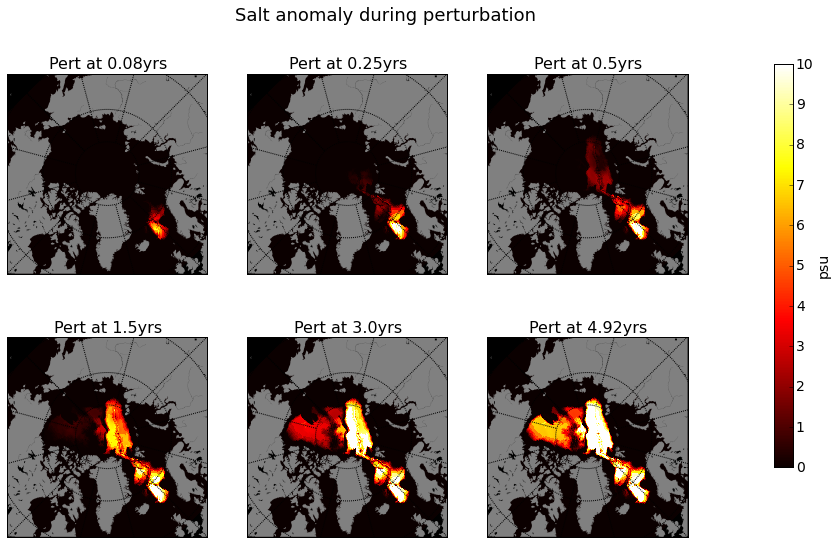

In [13]:
def basemap_perturbation(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = 0 ; vimax = 10
    fig, axes = plt.subplots(2,3)
            
    depth = np.tile([grid['Zp']],(len(data_pert.X),len(data_pert.Y),1))
    depth = np.swapaxes(depth,0,2) 
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        
        data = np.array(data_pert.data['S'][t,:,:,:])
        data1 = np.array(data_diff.data['S'][t,:,:,:])    
        datam = np.nansum(data*depth,axis=0)/np.abs(data_pert.Z[49]) - np.nansum(data1*depth,axis=0)/np.abs(data_pert.Z[49])
        #datam = np.nanmean((data_pert.data['S'] - data_diff.data['S'])[t,:,:,:],axis=0)
        
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.hot,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)
        ind += 1
    fig.suptitle("Salt anomaly during perturbation",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    fig.subplots_adjust(right=1.7,top=1.8)    
    fig.savefig('/noc/users/am8e13/Figures/perturbation_anom',dpi=dpires, bbox_inches='tight')
    
basemap_perturbation(pert_const,pert_bench,times)

#Barotropic Streamfunction

Perturbation generates strong currents particularly in the nordic seas spreading into the Arctic, we check barotropic streamfunction to study magnitude and features of the generated currents.

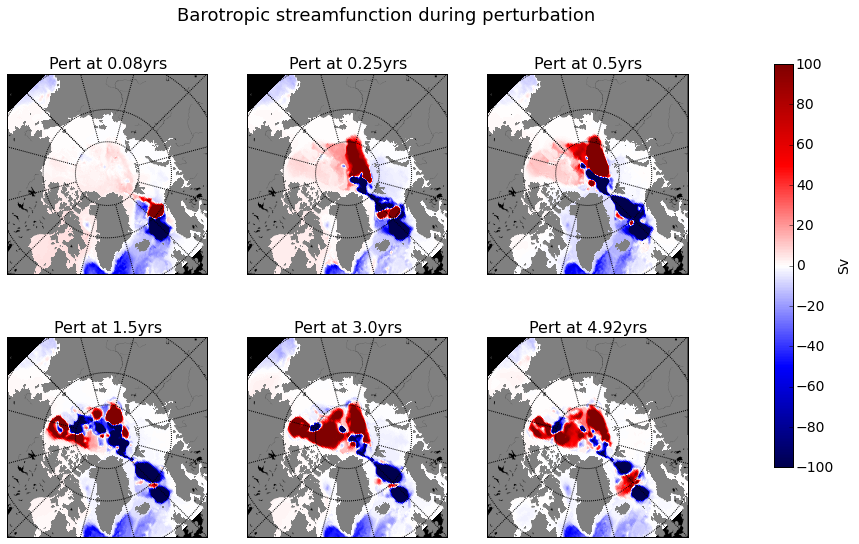

In [166]:
def basemap_perturbation(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = -100 ; vimax = 100
    fig, axes = plt.subplots(2,3)
    kres = {36:1,18:2,9:9}
    kk = kres[data_pert.res]
    cmap=matplotlib.cm.seismic
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        datam = data_pert.psi[t,0*kk:192*kk,0*kk:210*kk]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)
        ind += 1
    fig.suptitle("Barotropic streamfunction during perturbation",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'Sv',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    fig.subplots_adjust(right=1.7,top=1.8)  
    fig.savefig('/noc/users/am8e13/Figures/perturbation_barostream',dpi=dpires, bbox_inches='tight')
    
basemap_perturbation(pert_const,pert_bench,times)

In [167]:
def nanargmax(a):
    idx = np.nanargmax(a, axis=None)
    multi_idx = np.unravel_index(idx, a.shape)
    if np.isnan(a[multi_idx]):
        nan_count = np.sum(np.isnan(a))
        # In numpy < 1.8 use idx = np.argsort(a, axis=None)[-nan_count-1]
        idx = np.argpartition(a, -nan_count-1, axis=None)[-nan_count-1]
        multi_idx = np.unravel_index(idx, a.shape)
    return multi_idx

def nanargmin(a):
    idx = np.nanargmin(a, axis=None)
    multi_idx = np.unravel_index(idx, a.shape)
    if np.isnan(a[multi_idx]):
        nan_count = np.sum(np.isnan(a))
        # In numpy < 1.8 use idx = np.argsort(a, axis=None)[-nan_count-1]
        idx = np.argpartition(a, -nan_count-1, axis=None)[-nan_count-1]
        multi_idx = np.unravel_index(idx, a.shape)
    return multi_idx

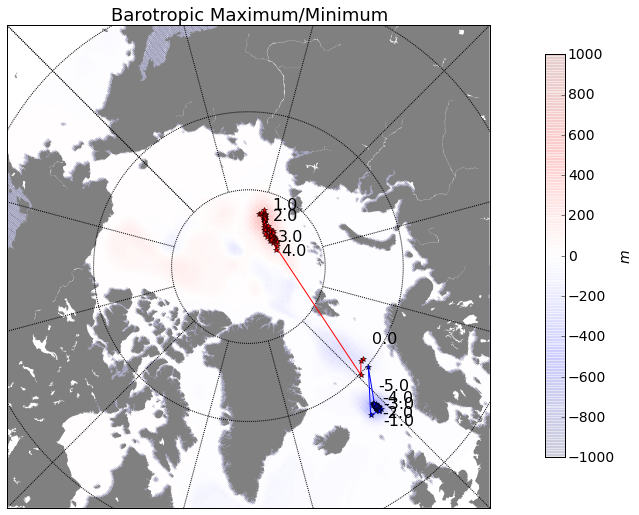

In [168]:
def basemap_bathy(data_pert):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;
    sgn=1
    width=7000000. ; height=7000000.0 ;
    vmin = -1000; vmax = 1000 ;

    inds_min = [] ; inds_max = [] ; inds_min2 = [] ;
    lat_max = [] ; lon_max = [] ; lat_min = [] ; lon_min = []; lat_min2 = [] ; lon_min2 = [];
    for t in range(62,120):
        ind = nanargmax(data_pert.psi[t,:,:])
        inds_max.append(ind)
        lat_max.append(grid['XC'][ind])
        lon_max.append(grid['YC'][ind])

        ind = nanargmin(data_pert.psi[t,:,:])
        inds_min.append(ind)
        lat_min.append(grid['XC'][ind])
        lon_min.append(grid['YC'][ind])
        
    fig, axes = plt.subplots(1,1)
    m = Basemap(ax=axes,width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
    # the continents will be drawn on top.
    m.drawmapboundary(fill_color='white')
    # fill continents, set lake color same as ocean color.
    m.fillcontinents(color='grey',lake_color='white')
    x,y=m(grid['XC'],grid['YC'])
    sitm = np.ma.masked_where(np.isnan(grid['HFacC'][0,:,:]),np.nanmean(data_pert.psi[:,0:384,0:420],axis=0))
    CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.seismic,vmin=vmin,vmax=vmax,alpha=0.1)
    m.drawparallels(np.arange(-80.,81.,15.))
    m.drawmeridians(np.arange(-180.,181.,30.))
    axes.set_title('Barotropic Maximum/Minimum',fontsize=18)
    
    x,y= m(lat_min,lon_min)
    m.plot(x,y,'b*-')
    
    for xx in range(len(x)):
        if xx%12 == 0:
            plt.text(x[xx]+300000,y[xx]+10000*(len(x)/2-xx),round(data_pert.years[60+xx],1)-10,fontsize=16,\
                 ha='center',va='center',color='black')
    
    x,y= m(lat_max,lon_max)
    m.plot(x,y,'r*-')
    
    for xx in range(len(x)):
        if xx%12 == 0:
            plt.text(x[xx]+300000,y[xx]+10000*(len(x)/2-xx),round(data_pert.years[60+xx],1)-5,fontsize=16,\
                 ha='center',va='center',color='black')
    
    cbar_ax = fig.add_axes([1.6, 0.3, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax)
    cbar.ax.set_ylabel(r'$m$')
    cbar.ax.tick_params(labelsize=14)
    fig.subplots_adjust(right=1.7,top=1.8)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_barostream_maxmin',dpi=dpires, bbox_inches='tight')

basemap_bathy(pert_const)

In [169]:
def reg_titles():
    region_titles = {0 : 'Global' , 1 : 'Arctic' , 2 : 'Nord Seas' , 3 : 'North Atl', 4: 'Norwegian' ,\
                     5: 'Greenland' , 6 : 'Lofoten' , 7 : 'Iceland Sea' , 8 : 'Labrador'}
    return region_titles

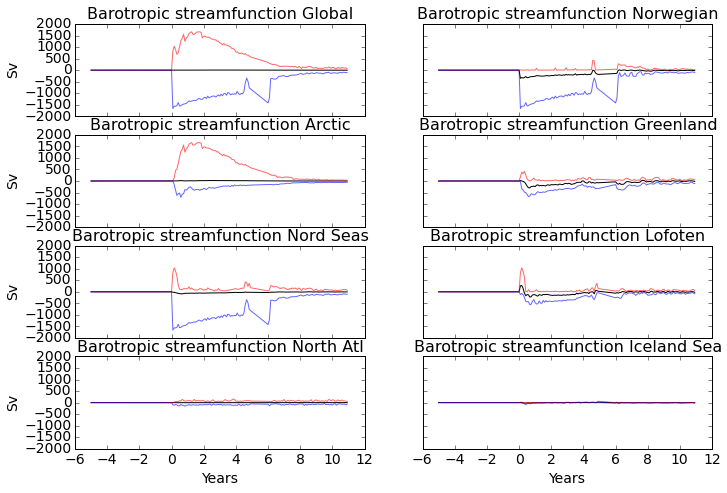

In [14]:
# Plot sea surface elevation per regions
def plot_dynStLayers(data_pert,data_diff,row=4,col=2):
    # this function is meant to plot monitor variables
    grid = grid_read(data_pert.res)
    mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8 = region_mask(data_pert.res)
    mask0 = np.ones_like(mask1)
    areamasks = {0:mask0 , 1 : mask1 , 2 : mask2 , 3 : mask3, \
                4 : mask4, 5 : mask5, 6 : mask6, 7: mask7, 8 : mask8}
    region_titles = reg_titles()
    fig, axes = plt.subplots(row,col,sharex=True,sharey=True)
    ax_ind = 0
    alphavar = {'mean':1,'max':0.6,'min':0.6}
    colvar = {'mean':'black','max':'red','min':'blue'}
    for reg in [0,4,1,5,2,6,3,7]:
        maskcalc = np.tile(areamasks[reg][0,:,:],(data_pert.data['Eta'].shape[0],1,1))
        data = np.array(data_pert.psi[:,:,0:data_pert.psi.shape[2]-1])
        data1 = np.array(data_diff.psi)[0:data.shape[0],:,0:data_pert.psi.shape[2]-1]
        datam = (data - data1)*maskcalc            
        datadic = {'mean' : np.nanmean(np.nanmean(datam[:,:,:],axis=2),axis=1) ,
                   'max'  : np.nanmax(np.nanmax(datam[:,:,:],axis=2),axis=1) ,
                   'min'  : np.nanmin(np.nanmin(datam[:,:,:],axis=2),axis=1) }                
        for var in ['mean','max','min']:
            axes.flat[ax_ind].plot(data_pert.years[:]-5,datadic[var][:],color=colvar[var],
                                  alpha=alphavar[var])
            axes.flat[ax_ind].set_title('Barotropic streamfunction '+region_titles[reg],fontsize=16)
            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)
            if (ax_ind)%2 == 0:
                axes.flat[ax_ind].set_ylabel('Sv',fontsize=14)
            axes.flat[6].set_xlabel('Years',fontsize=14)
            axes.flat[7].set_xlabel('Years',fontsize=14)
        ax_ind += 1
    fig.subplots_adjust(right=1.6,top=1.6)
    
    fig.savefig('/noc/users/am8e13/Figures/perturbation_psi_reg',dpi=dpires, bbox_inches='tight')

plot_dynStLayers(pert_const,pert_bench)

# Steric response 

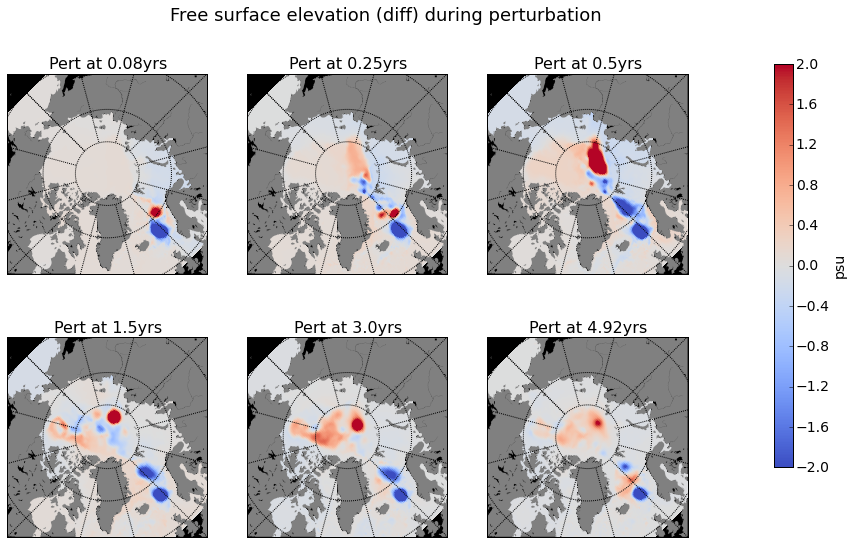

In [171]:
def basemap_ETA(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = -2 ; vimax = 2
    fig, axes = plt.subplots(2,3)
    kres = {36:1,18:2,9:9}
    kk = kres[data_pert.res]
    cmap=matplotlib.cm.coolwarm
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        datam = data_pert.data['Eta'][t,:,:] - data_diff.data['Eta'][t,:,:]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)
        ind += 1
    fig.suptitle("Free surface elevation (diff) during perturbation",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    fig.subplots_adjust(right=1.7,top=1.8)    
    fig.savefig('/noc/users/am8e13/Figures/perturbation_ssh',dpi=dpires, bbox_inches='tight')
    
basemap_ETA(pert_const,pert_bench,times)

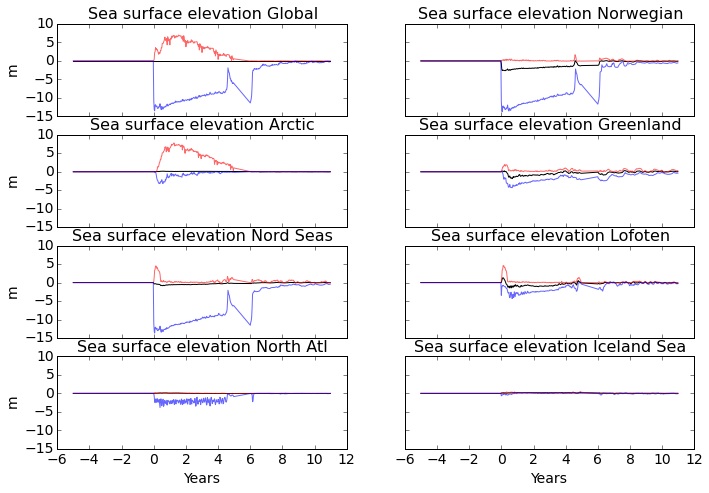

In [15]:
# Plot sea surface elevation per regions
def plot_dynStLayers(data_pert,data_diff,row=4,col=2):
    # this function is meant to plot monitor variables   
    region_titles = reg_titles()
    fig, axes = plt.subplots(row,col,sharex=True,sharey=True)
    ax_ind = 0
    var_s = ['eta_mean','eta_min','eta_max']
    vartitles = {'eta_mean' : 'Eta Mean','eta_max' : 'Eta Max','eta_min' : 'Eta Min'}
    alphavar = {'eta_mean':1,'eta_max':0.6,'eta_min':0.6}
    colvar = {'eta_mean':'black','eta_max':'red','eta_min':'blue'}
    for reg in [0,4,1,5,2,6,3,7]:
        for var in ['eta_mean','eta_max','eta_min']:
            data = data_pert.dataDyn[var][1:,reg,0] - data_diff.dataDyn[var][1:len(data_pert.dataDyn[var][1:,reg,0])+1,reg,0]
            axes.flat[ax_ind].plot(data_pert.dataDyn['time_lv_years'][:]-5,data[:],color=colvar[var],
                                  alpha=alphavar[var])
            #axes.flat[ax_ind].plot(data_pert.dataDyn['time_lv_years'][0:-12*3],\
            #                   runningMeanFast(data,12*3)[0:-12*3],data_pert.color)
            axes.flat[ax_ind].set_title('Sea surface elevation '+region_titles[reg],fontsize=16)
            if (ax_ind)%2 == 0:
                axes.flat[ax_ind].set_ylabel('m',fontsize=14)
            axes.flat[6].set_xlabel('Years',fontsize=14)
            axes.flat[7].set_xlabel('Years',fontsize=14)

            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)

        ax_ind += 1
    fig.subplots_adjust(right=1.6,top=1.6)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_ssh_regions',dpi=dpires, bbox_inches='tight')

plot_dynStLayers(pert_const,pert_bench)

# Steric effect

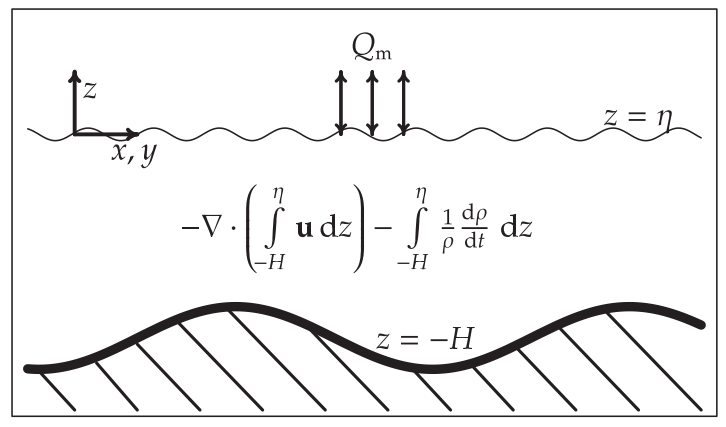

In [173]:
from IPython.display import Image
Image(filename='/users/admin/am8e13/steric.png') 

Evolution of the free surface:
$$
\frac{\partial \eta}{\partial t} = \frac{Q_m}{\rho(\eta)} - \nabla\cdot\int_{-H}^{\eta}\textbf{u}dz - \int_{-H}^{\eta} \frac{1}{\rho}\frac{d\rho}{dt}dz
$$
where $\rho$ is:
$$
\rho(\eta) = \rho(x,y,z=\eta(x,y,t),t)
$$

In the following we calculate the steric perturbation using the following formula:
\begin{equation}
h_{steric}(x, y, t) = \int_{D}^{0} \frac{\rho_0(x, y, z)-\rho(x, y, z, t)}{\rho_0(x, y, z)}dz
\end{equation}

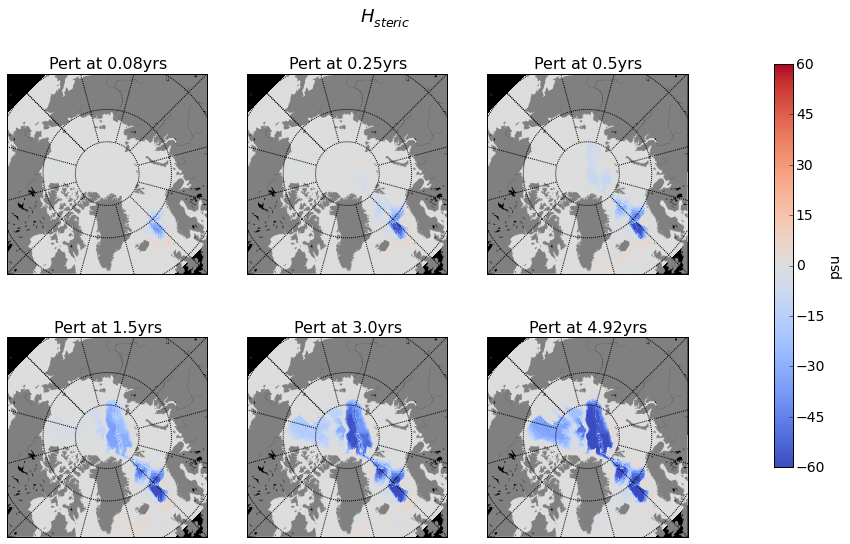

In [174]:
def basemap_ETA(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = -60 ; vimax = 60
    fig, axes = plt.subplots(2,3)
    kres = {36:1,18:2,9:9}
    kk = kres[data_pert.res]
    cmap=matplotlib.cm.coolwarm
    depth = np.tile([grid['Zp']],(len(data_pert.X),len(data_pert.Y),1))
    depth = np.swapaxes(depth,0,2) 
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        hist = np.zeros_like(data_diff.data['S'][0,:,:,:])
        for z in range(hist.shape[0]):
            rho0 = densjmd95(data_diff.data['S'][t,z,:,:],data_diff.data['T'][t,z,:,:],-9.81*data_diff.Z[z]*1025)
            rho  = densjmd95(data_pert.data['S'][t,z,:,:],data_pert.data['T'][t,z,:,:],-9.81*data_pert.Z[z]*1025)
            hist[z,:,:] = ((rho0 - rho) / rho0)
        datam = np.nansum(depth*hist,axis=0)
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)
        ind += 1
    fig.suptitle(r"$H_{steric}$",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    fig.subplots_adjust(right=1.7,top=1.8)    
    fig.savefig('/noc/users/am8e13/Figures/perturbation_hsteric',dpi=dpires, bbox_inches='tight')
    
basemap_ETA(pert_const,pert_bench,times)

0.0 -0.00058547916768
0.0 -0.000439473987599
0.0 -0.00126542582101
0.0 -0.00126542582101
0.000686525967345 -0.000142410661388


IndexError: index 120 is out of bounds for axis 0 with size 120

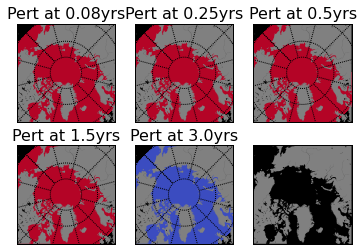

In [175]:
def basemap_ETA(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = -200 ; vimax = 200
    fig, axes = plt.subplots(2,3)
    kres = {36:1,18:2,9:9}
    kk = kres[data_pert.res]
    cmap=matplotlib.cm.coolwarm
    depth = np.tile([grid['Zp']],(len(data_pert.X),len(data_pert.Y),1))
    depth = np.swapaxes(depth,0,2) 
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        hsteric = np.zeros_like(data_diff.data['S'][0,:,:,:])
        for z in range(hsteric.shape[0]):
            rho1 = densjmd95(data_diff.data['S'][t+1,z,:,:],data_diff.data['T'][t+1,z,:,:],-9.81*data_diff.Z[z]*1025)
            rho  = densjmd95(data_pert.data['S'][t,z,:,:],data_pert.data['T'][t,z,:,:],-9.81*data_pert.Z[z]*1025)
        
        hsteric = (rho1 - rho)/rho1
        inthsteric = np.nansum(depth*hsteric, axis=0)
        
        print inthsteric.max(),inthsteric.min()
        
        # calculation of grad int u
        intv = np.nansum(depth*data_pert.data['V'][t,:,0*kk*kk:192*kk,0*kk:210*kk],axis=0)
        intu = np.nansum(depth*data_pert.data['U'][t,:,0*kk*kk:192*kk,0*kk:210*kk],axis=0)
        nablavel = np.gradient(intu)[0] + np.gradient(intv)[1]
        #datam = nablavel + inthsteric
        datam = inthsteric
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap)#,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)
        ind += 1
    fig.suptitle(r"$H_{steric}$",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    fig.subplots_adjust(right=1.7,top=1.8)    
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_hsteric',dpi=dpires, bbox_inches='tight')
    
basemap_ETA(pert_const,pert_bench,times)

In [ ]:
from IPython.display import Image
Image(filename='/users/admin/am8e13/steric2.png') 

In [ ]:
def basemap_eta_max_min(data_pert,data_diff):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;
    sgn=1
    width=7000000. ; height=7000000.0 ;
    vmin = -3; vmax = 3 ;
    
    inds_min = [] ; inds_max = [] ; inds_min2 = [] ;
    lat_max = [] ; lon_max = [] ; lat_min = [] ; lon_min = []; lat_min2 = [] ; lon_min2 = [];
    for t in range(61,120):
        ind = nanargmax(data_pert.data['Eta'][t,:,:]-data_diff.data['Eta'][t,:,:])
        inds_max.append(ind)
        lat_max.append(grid['XC'][ind])
        lon_max.append(grid['YC'][ind])
        
        ind = nanargmin(data_pert.data['Eta'][t,:,:]-data_diff.data['Eta'][t,:,:])
        inds_min.append(ind)
        lat_min.append(grid['XC'][ind])
        lon_min.append(grid['YC'][ind])

    fig, axes = plt.subplots(1,1)
    m = Basemap(ax=axes,width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
    # the continents will be drawn on top.
    m.drawmapboundary(fill_color='white')
    # fill continents, set lake color same as ocean color.
    m.fillcontinents(color='grey',lake_color='white')
    x,y=m(grid['XC'],grid['YC'])
    sitm = np.ma.masked_where(np.isnan(grid['HFacC'][0,:,:]),np.nanmean(data_pert.data['Eta'][60:,0:384,0:420],axis=0))
    CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.seismic,vmin=vmin,vmax=vmax,alpha=0.1)
    m.drawparallels(np.arange(-80.,81.,15.))
    m.drawmeridians(np.arange(-180.,181.,30.))
    axes.set_title('Sea surface height Maximum/Minimum',fontsize=18)
    
    x,y= m(lat_min,lon_min)
    m.plot(x,y,'b*-')
    
    for xx in range(len(x)):
        if xx%12 == 0:
            plt.text(x[xx]+300000,y[xx]+10000*(len(x)/2-xx),round(data_pert.years[60+xx],1)-5,fontsize=16,\
                 ha='center',va='center',color='black')
    
    x,y= m(lat_max,lon_max)
    m.plot(x,y,'r*-')
    
    for xx in range(len(x)):
        if xx%12 == 0:
            plt.text(x[xx]+300000,y[xx]+10000*(len(x)/2-xx),round(data_pert.years[60+xx],1)-5,fontsize=16,\
                 ha='center',va='center',color='black')
    
    cbar_ax = fig.add_axes([1.6, 0.3, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax)
    cbar.ax.set_ylabel(r'$m$')
    cbar.ax.tick_params(labelsize=14)
    fig.subplots_adjust(right=1.7,top=1.8)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_ssh_maxmin',dpi=dpires, bbox_inches='tight')

basemap_eta_max_min(pert_const,pert_bench)

# Various gif

In [ ]:
def basemap_gif(data_pert,data_diff):
    # This function produces a gif animation of the field                                                       
    # All the parameters are the same as the previous                                                            
    title = 'pres_pert_circ'
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1; width=7000000. ; height=7000000.0
    fields_dic = {0 : np.nanmean(data_pert.data['S'] - data_diff.data['S'],axis=1),
                  1 : data_pert.data['Eta'] - data_diff.data['Eta'],                  
                  2 : data_pert.psi[:,0:384,0:420] - data_diff.psi[:,0:384,0:420],
                  3 : np.nanmean(np.sqrt(data_pert.data['V'][:,:,0:384,0:420]**2 + \
                                         data_pert.data['U'][:,:,0:384,0:420]**2) -
                                 np.sqrt(data_diff.data['V'][:,:,0:384,0:420]**2 + \
                                         data_diff.data['U'][:,:,0:384,0:420]**2),axis=1)}

    titles_dic = {0 : 'Salt Anomaly' , 1 : 'Sea surface height' , 2 : 'Barotropic Streamfunction' , \
                  3 : 'Velocity magnitude'}
    cmap_dic = { 0 : matplotlib.cm.hot ,  1 : matplotlib.cm.RdBu_r , 2 : matplotlib.cm.seismic ,
                3 : matplotlib.cm.jet }
    unit_dic = {0 : 'psu' , 1 : 'm' , 2 : 'Sv', 3 : r'm/s'}
    vmin_dic = {0 : 0 , 1 : -2 , 2 : -100 , 3 : 0}
    vmax_dic = {0 : 10 , 1 : 2 , 2 : 100 , 3 : 7 }
    
    fig, axes = plt.subplots(2,2)
    for t in range(57,75,1)+range(75,90,2)+range(90,120,3):
        for k in range(4):
            m = Basemap(ax=axes.flat[k],width=width,height=height,resolution='l',\
                        projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
            # the continents will be drawn on top.
            m.drawmapboundary(fill_color='black')
            # fill continents, set lake color same as ocean color.
            m.fillcontinents(color='grey',lake_color='black')
            x,y=m(data_pert.lon,data_pert.lat)
            datam = fields_dic[k][t,:,:]
            sitm = np.ma.masked_where(np.isnan(datam),datam)
            CS=m.pcolormesh(x,y,sitm,cmap=cmap_dic[k],vmin=vmin_dic[k],vmax=vmax_dic[k])
            m.drawparallels(np.arange(-80.,81.,15.))
            m.drawmeridians(np.arange(-180.,181.,30.))
            cbar = m.colorbar(CS)
            cbar.set_label(unit_dic[k])
            axes.flat[k].set_title(titles_dic[k],fontsize=16)
        fig.suptitle('Perturbation at '+str(round(data_pert.years[t]-5,2))+' years',x=0.9,y=1.95,fontsize=21)
        fig.subplots_adjust(right=1.7,top=1.8)    
        
        if t < 10:
            zeros = '000'
        elif t < 100:
            zeros = '00'
        else:
            zeros = '0'
        sout = '/scratch/general/am8e13/gifs/'
        fig.savefig(sout+title+zeros+str(t)+'.png',dpi=300, bbox_inches='tight')
        clf
    os.system("convert -delay 50 -dispose Background +page " + str(sout) \
          + "/*.png -loop 0 " + str(sout) + "/animation_"+title+".gif")
    os.system("rm "+str(sout)+"*png")
    sout = '/scratch/general/am8e13/gifs/'
    
basemap_gif(pert_const,pert_bench)

In [ ]:
def basemap_gif(data_pert,data_diff):
    # This function produces a gif animation of the field
    title = 'pres_pert_hchw'
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1; width=7000000. ; height=7000000.0
    fields_dic = {0 : data_pert.heat_content*1000*4.202/10**14 - data_diff.heat_content*1000*4.202/10**14,
                  1 : data_pert.freswater_content/10**8 -  data_diff.freswater_content/10**8}
    titles_dic = {0 : 'Heat content' , 1 : 'Freshwater content'}
    cmap_dic = { 0 : matplotlib.cm.RdYlBu_r , 1 : matplotlib.cm.PuOr_r }
    unit_dic = {0 : 'J' , 1 : 'm' , 2 : 'psu', 3 : r'$J * 10^{14}$'}
    vmin_dic = {0 : -20 , 1 : -10 , 2 : 31 , 3 : -10}
    vmax_dic = {0 : 20 , 1 : 10 , 2 : 36 , 3 : 10 }
    
    fig, axes = plt.subplots(1,2)
    for t in range(57,75,1)+range(75,90,2)+range(90,120,3):
        for k in range(2):
            m = Basemap(ax=axes.flat[k],width=width,height=height,resolution='l',\
                        projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
            # the continents will be drawn on top.
            m.drawmapboundary(fill_color='black')
            # fill continents, set lake color same as ocean color.
            m.fillcontinents(color='grey',lake_color='black')
            x,y=m(data_pert.lon,data_pert.lat)
            datam = fields_dic[k][t,:,:]
            sitm = np.ma.masked_where(np.isnan(datam),datam)
            CS=m.pcolormesh(x,y,sitm,cmap=cmap_dic[k],vmin=vmin_dic[k],vmax=vmax_dic[k])
            m.drawparallels(np.arange(-80.,81.,15.))
            m.drawmeridians(np.arange(-180.,181.,30.))
            cbar = m.colorbar(CS)
            cbar.set_label(unit_dic[k])
            axes.flat[k].set_title(titles_dic[k],fontsize=16)
        fig.suptitle('Perturbation at '+str(round(data_pert.years[t]-5,2))+' years',x=0.9,y=1.7,fontsize=21)
        fig.subplots_adjust(right=1.7,top=1.8)    
        
        if t < 10:
            zeros = '000'
        elif t < 100:
            zeros = '00'
        else:
            zeros = '0'
        sout = '/scratch/general/am8e13/gifs/'
        fig.savefig(sout+title+zeros+str(t)+'.png',dpi=300, bbox_inches='tight')
        clf
    os.system("convert -delay 50 -dispose Background +page " + str(sout) \
          + "/*.png -loop 0 " + str(sout) + "/animation_"+title+".gif")
    os.system("rm "+str(sout)+"*png")
    sout = '/scratch/general/am8e13/gifs/'
    
basemap_gif(pert_const,pert_bench)

In [ ]:
def basemap_gif(data_pert,data_diff):
    # This function produces a gif animation of the field                                                                                                                                           
    # All the parameters are the same as the previous 
    title = 'pres_pert_TS'
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1; width=7000000. ; height=7000000.0
    fields_dic = {0 : np.nanmean(data_pert.data['S'] - data_diff.data['S'],axis=1),
                  1 : np.nanmean(data_pert.data['T'][:,0:20,:,:],axis=1),                  
                  2 : np.nanmean(data_pert.data['S'][:,0:20,:,:],axis=1) }
    titles_dic = {0 : 'Salt Anomaly' , 1 : 'Temperature top 600m' , 2 : 'Salinity top 600m'}
    cmap_dic = { 0 : matplotlib.cm.hot ,  1 : cmocean.cm.temperature , 2 : cmocean.cm.salinity ,
                3 : matplotlib.cm.RdYlBu_r }
    unit_dic = {0 : 'psu' , 1 : '$^{\circ}C$' , 2 : 'psu', 3 : r'$J * 10^{14}$'}
    vmin_dic = {0 : 0 , 1 : -3 , 2 : 31 , 3 : -10}
    vmax_dic = {0 : 10 , 1 : 15 , 2 : 36 , 3 : 10 }
    
    fig, axes = plt.subplots(1,3)
    for t in range(57,75,1)+range(75,90,2)+range(90,120,3):#range(65,66,1):
        for k in range(3):
            m = Basemap(ax=axes.flat[k],width=width,height=height,resolution='l',\
                        projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
            # the continents will be drawn on top.
            m.drawmapboundary(fill_color='black')
            # fill continents, set lake color same as ocean color.
            m.fillcontinents(color='grey',lake_color='black')
            x,y=m(data_pert.lon,data_pert.lat)
            datam = fields_dic[k][t,:,:]
            sitm = np.ma.masked_where(np.isnan(datam),datam)
            CS=m.pcolormesh(x,y,sitm,cmap=cmap_dic[k],vmin=vmin_dic[k],vmax=vmax_dic[k])
            m.drawparallels(np.arange(-80.,81.,15.))
            m.drawmeridians(np.arange(-180.,181.,30.))
            cbar = m.colorbar(CS)
            cbar.set_label(unit_dic[k])
            axes.flat[k].set_title(titles_dic[k],fontsize=16)
        fig.suptitle('Perturbation at '+str(round(data_pert.years[t]-5,2))+' years',x=0.9,y=1.5,fontsize=21)
        fig.subplots_adjust(right=1.7,top=1.8)    
        
        if t < 10:
            zeros = '000'
        elif t < 100:
            zeros = '00'
        else:
            zeros = '0'
        sout = '/scratch/general/am8e13/gifs/'
        fig.savefig(sout+title+zeros+str(t)+'.png',dpi=300, bbox_inches='tight')
        clf
    os.system("convert -delay 50 -dispose Background +page " + str(sout) \
          + "/*.png -loop 0 " + str(sout) + "/animation_"+title+".gif")
    os.system("rm "+str(sout)+"*png")
    sout = '/scratch/general/am8e13/gifs/'
    
basemap_gif(pert_const,pert_bench)

# Fluxes

Most of the flux seems to go through Fram strait, very little through Barents strait or Denmark strait, we check fluxes to confirm this

Fluxes are positives for fluxes into the Arctic

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


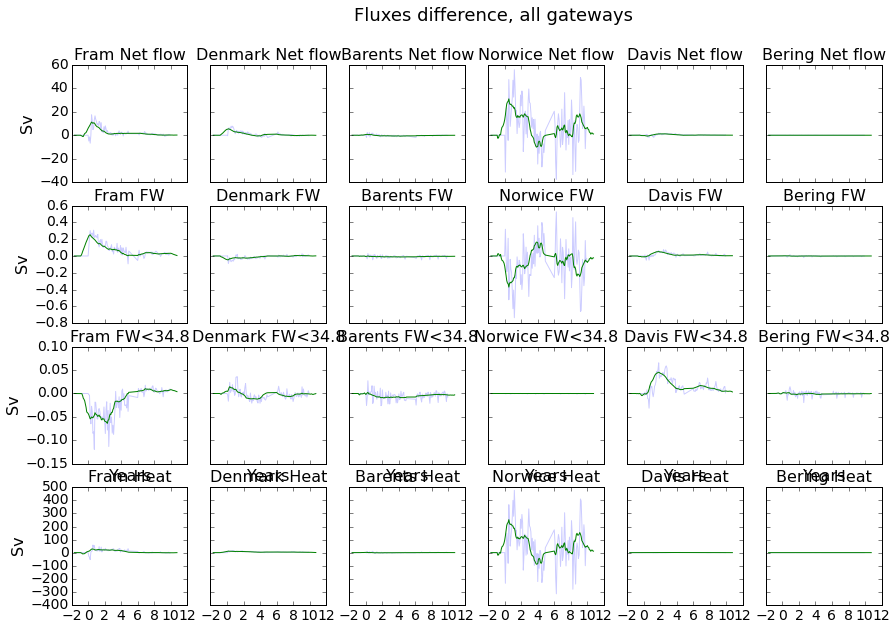

In [16]:
# plot layers
def plot_flux_total_diff(data_pert,data_diff):
    # this function is meant to plot monitor variables   
    ax_ind = 0
    fluxes = ['FluxSum','FluxSumFW','FluxSumFW1','FluxSumT']#
    variables = ['Fram','Denmark','Barents','Norwice','Davis','Bering']
    #variables = ['Fram','Denmark']
    flux_titles = {'FluxSumFW' : 'FW','FluxSumFW1' : 'FW<34.8','FluxSumS' : 'S', 'FluxSumT':'Heat', \
                   'FluxInSum' : 'Inflow','FluxOutSum' : 'Outflow' , 'FluxSum' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2' : 'Norwice2' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    iniz = 40
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for flux in fluxes:
        for var in variables:  
            data = data_pert.fluxes[var][flux]-data_diff.fluxes[var][flux]
            axes.flat[ax_ind].plot(data_pert.years[iniz:-12]-5,data[iniz:-12],alpha=0.2)
            axes.flat[ax_ind].plot(data_pert.years[iniz:-2]-5,runningMeanFast(data,12)[iniz:-2])
            axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
            if ax_ind%len(variables)==0:
                axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
            if ax_ind/len(variables)==2:
                axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
            axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
            ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference, all gateways",x=1.1,y=2.2,fontsize=18)  
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_flows_allgate',dpi=dpires, bbox_inches='tight')

plot_flux_total_diff(pert_const,pert_bench,)

In [281]:
def grid_read(res):
    ''' use: grid = grid_read(res) '''
    path = "/scratch/general/am8e13/results"+str(res)+"km/grid.nc"
    file2read = netcdf.NetCDFFile(path,'r')
    # Bathy is 1 on land and 0 over sea                                                                                                       
    grid = {}
    for var in ['HFacC','HFacW','HFacS','YC','XC','Z','Y','X','rA','Depth','fCori']:
        temp = file2read.variables[var]
        grid[var] = temp[:]*1
    file2read.close()
    area = np.zeros_like(grid['HFacC'])
    Zp = [10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
             10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04 , 19.82, 24.85,
             31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
             93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
             139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
             341.50,364.50,387.50,410.50,433.50,456.50 ]
    for z in range(len(grid['Z'])):
        area[z,:,:] = grid['HFacC'][z,:,:]*grid['rA']*Zp[z]
    grid['Area'] = area
    grid['Zp'] = Zp
    return grid
grid = grid_read(18)


<matplotlib.colorbar.Colorbar instance at 0x2b0002870320>

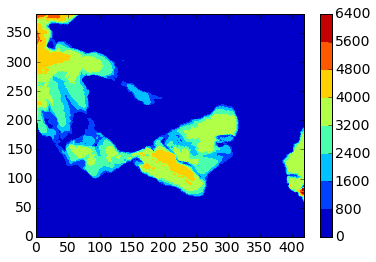

In [299]:
plt.contourf(grid['Depth'])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2ae7b1cacea8>

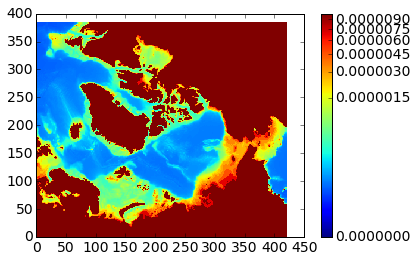

In [309]:
fh = grid['fCori']/grid['Depth']
#fh[fh<0.000000001] = 0.000000001
#fh[np.isnan(fh)] = 0.000000001
plt.pcolormesh(fh,vmin=0,vmax=0.00001,norm=matplotlib.colors.PowerNorm(gamma=1./4.))
plt.colorbar()

From the fluxes we can see that

- There is a net outflow from the Arctic, this is particularly relalted to the uppper layers, transporting large amount of freshwater.
- Strong flow throuhg Denmark strait, flow from the Nordic Seas into the North Atlantic. Flow transporting freshwater.

Strong fluxes mostly through Fram strait, both incoming and outcoming

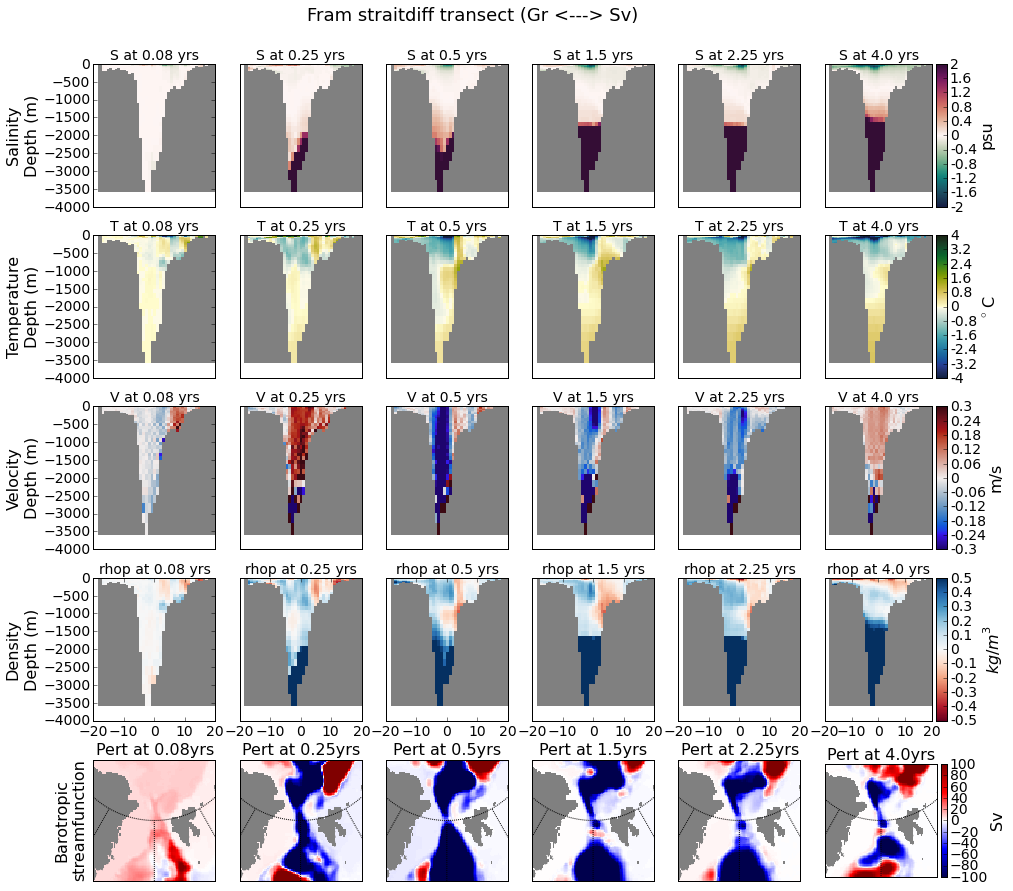

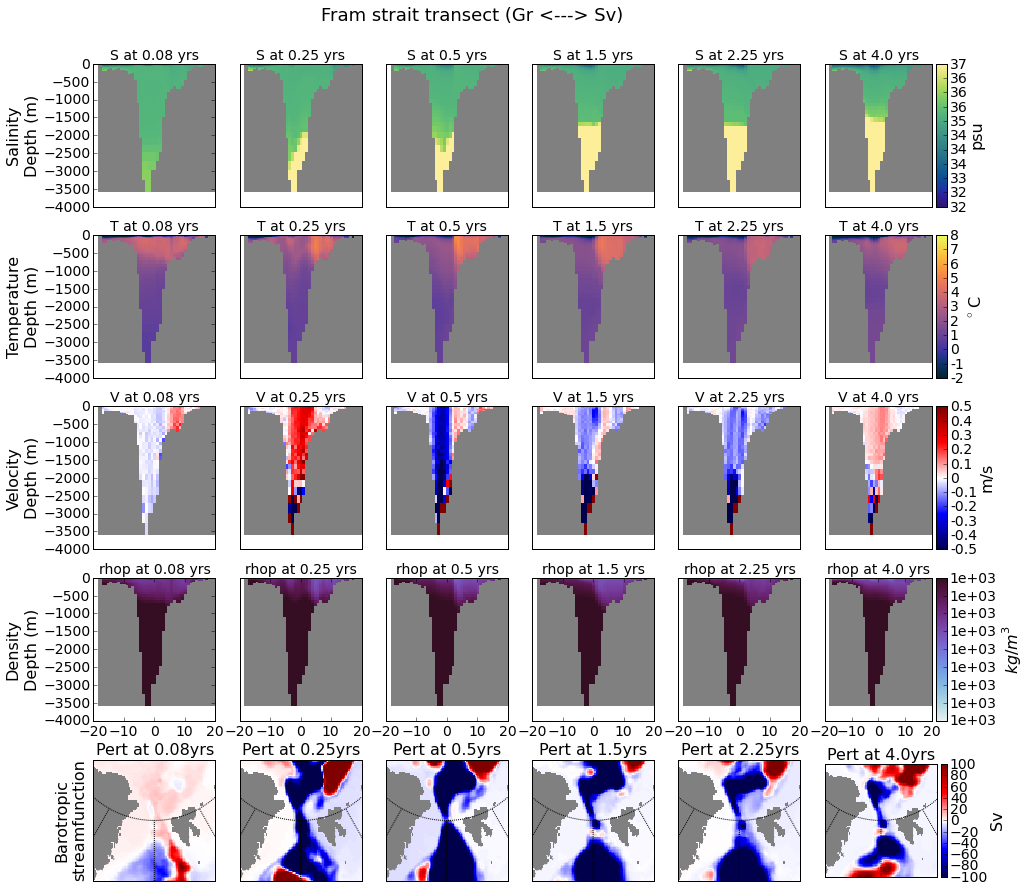

In [275]:
def strait_flux_fram(data_pert,data_diff,times,diff=True):
    ind = 0
    variables = ['S','T','V','rhop']
    vartitle = {'S':'psu' , 'T' : r'$^{\circ}$C' , 'V': 'm/s' , 'rhop' : r'$kg/m^3$'}
    verttit = {'S':'Salinity','T':'Temperature','V':'Velocity','rhop':'Density'}
    if diff:
        cmaps = {'S' : cmocean.cm.vort, 'T' : cmocean.cm.vel , 'V' : cmocean.cm.freesurface,\
                     'rhop' : matplotlib.cm.RdBu }    
        vmins = {'S' : -2, 'T' :-4 , 'V' : -0.3 , 'rhop' : -0.5  }
        vmaxs = {'S' : 2, 'T' : 4, 'V' : 0.3 , 'rhop' : 0.5}
        difftitle = 'diff'
    else:
        cmaps = {'S' : cmocean.cm.salinity, 'T' : cmocean.cm.temperature , 'V' : matplotlib.cm.seismic,\
                'rhop' : cmocean.cm.density}
        vmins = {'S' : 32, 'T' :-2 , 'V' : -0.5 , 'rhop' : 1026.5 }
        vmaxs = {'S' : 37, 'T' : 8, 'V' : 0.5 , 'rhop' : 1028.5}
        difftitle = ''

    kres = {36:1,18:2,9:4}
    k = kres[data_pert.res]
    fig, axes = plt.subplots(len(variables)+1,len(times))#,sharex=True, sharey=True)     
    for var in variables:
        for t in times:
            cmap = cmaps[var]
            cmap.set_bad('grey',1.) 
            if diff:
                toplot = data_pert.data[var][t,0:44,58*k:80*k,76*k] - data_diff.data[var][t,0:44,58*k:80*k,76*k]
            else:
                toplot = data_pert.data[var][t,0:44,58*k:80*k,76*k]
            imdata = np.ma.masked_invalid(toplot)
            CS = axes.flat[ind].pcolormesh(grid['XC'][58*k:80*k,76*k],data_pert.Z[0:44],imdata,
                    vmin=vmins[var],vmax=vmaxs[var],cmap = cmap)       
            axes.flat[ind].set_title(var+' at '+str(round(data_pert.years[t],2) - 5)+' yrs',fontsize=16)
            axes.flat[ind].title.set_fontsize('14')
            axes.flat[ind].tick_params(axis='both', which='major', labelsize=14)            
            axes.flat[ind].set_xticks([-20,-10,0,10,20])
            if ind%len(times)==0:
                axes.flat[ind].set_ylabel(verttit[var]+'\nDepth (m)',fontsize=16)
            else: 
                axes.flat[ind].get_yaxis().set_visible(False)
            if ind/len(times)-1==2:
                ''
                #axes.flat[ind].set_xlabel(r'Lon ($^{\circ}$)',fontsize=16)
            else:
                axes.flat[ind].get_xaxis().set_visible(False)
            ind += 1
        div = make_axes_locatable(axes.flat[ind-1])
        cax = div.append_axes("right", size="10%", pad=0.05)
        cbar = plt.colorbar(CS, cax=cax, format="%.2g")
        cbar.set_label(vartitle[var], size=16)
        cbar.ax.tick_params(labelsize=14)
        
    lat_ts=90.0 ; lat_0=80.0 ; lon_0=0.0 ;sgn=1
    width=1500000. ; height=1500000.0
    
    vimin = -100 ; vimax = 100
    kres = {36:1,18:2,9:9}
    kk = kres[data_pert.res]
    cmap=matplotlib.cm.seismic

    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        if diff:
            datam = data_pert.psi[t,0*kk:192*kk,0*kk:210*kk]-data_diff.psi[t,0*kk:192*kk,0*kk:210*kk]
        else:
            datam = data_pert.psi[t,0*kk:192*kk,0*kk:210*kk]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)        
        if ind%len(times)==0:
            axes.flat[ind].set_ylabel('Barotropic\nstreamfunction',fontsize=16)
        ind += 1
    div = make_axes_locatable(axes.flat[ind-1])
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(CS, cax=cax,)
    cbar.set_label('Sv', size=16)
    cbar.ax.tick_params(labelsize=14)

    fig.suptitle("Fram strait"+difftitle+" transect (Gr <---> Sv)",x=1.,y=3.2,fontsize=18)      
    fig.subplots_adjust(right=2.1,top=3.)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_fram'+difftitle,dpi=dpires, bbox_inches='tight')

strait_flux_fram(pert_const,pert_bench,times)
strait_flux_fram(pert_const,pert_bench,times,diff=False)

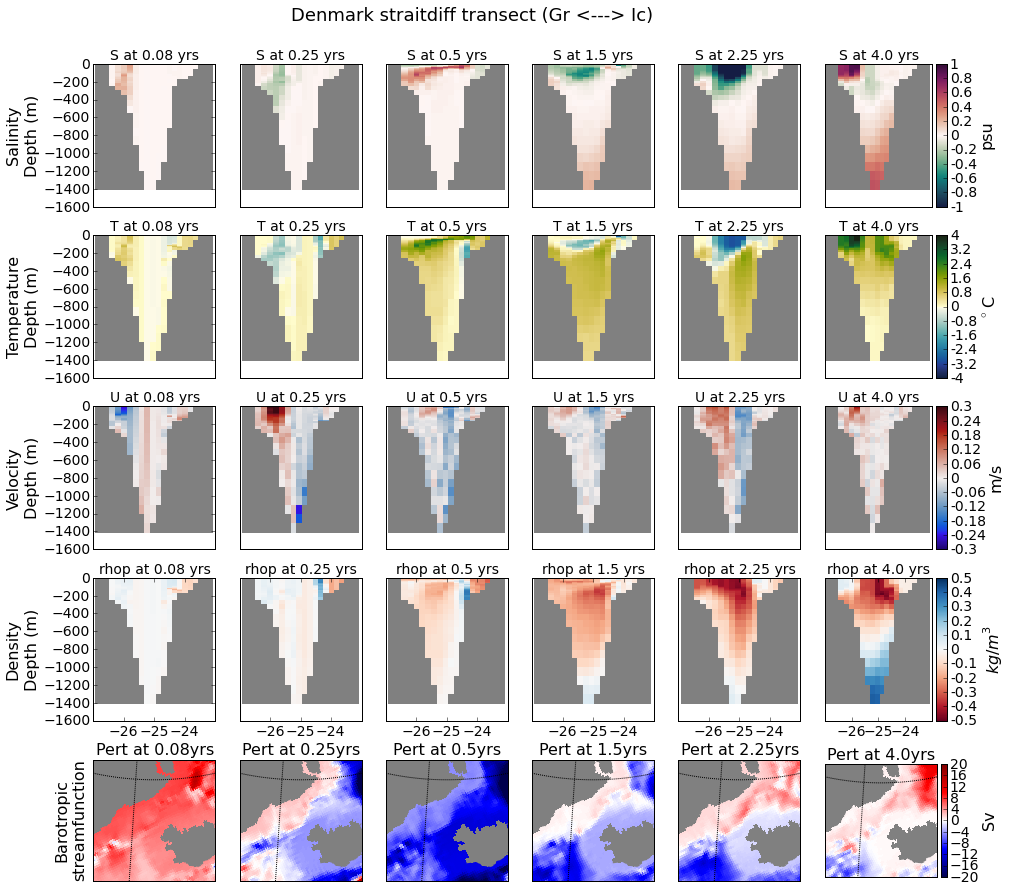

In [203]:
times = [1+12*5, 3+12*5, 6+12*5,18+12*5,27+12*5,48+12*5]

def strait_flux_denmark(data_pert,data_diff,times,diff=True):
    ind = 0
    variables = ['S','T','U','rhop']
    vartitle = {'S':'psu' , 'T' : r'$^{\circ}$C' , 'U': 'm/s' , 'rhop' : r'$kg/m^3$'}
    verttit = {'S':'Salinity','T':'Temperature','U':'Velocity','rhop':'Density'}
    if diff:
        cmaps = {'S' : cmocean.cm.vort, 'T' : cmocean.cm.vel , 'U' : cmocean.cm.freesurface, \
                 'rhop' : matplotlib.cm.RdBu}    
        vmins = {'S' : -1, 'T' :-4 , 'U' : -0.3 , 'rhop' : -0.5 }
        vmaxs = {'S' : 1, 'T' : 4, 'U' : 0.3 , 'rhop' : 0.5}
        difftitle = 'diff'
    else:
        cmaps = {'S' : cmocean.cm.salinity, 'T' : cmocean.cm.temperature , 'U' : matplotlib.cm.seismic,\
                'rhop' : cmocean.cm.density}
        vmins = {'S' : 32, 'T' :-2 , 'U' : -0.5 , 'rhop' : 1026.5}
        vmaxs = {'S' : 35, 'T' : 8, 'U' : 0.5, 'rhop' : 1028.5}
        difftitle = ''

    kres = {36:1,18:2,9:4}
    k = kres[data_pert.res]
    fig, axes = plt.subplots(len(variables)+1,len(times))#,sharex='col', sharey='row')        
    for var in variables:
        for t in times:
            cmap = cmaps[var]
            cmap.set_bad('grey',1.) 
            if diff:
                toplot = data_pert.data[var][t,0:33,100*k,37*k:48*k] - data_diff.data[var][t,0:33,100*k,37*k:48*k]
            else:
                toplot = data_pert.data[var][t,0:33,100*k,37*k:48*k]
            imdata = np.ma.masked_invalid(toplot)
            CS = axes.flat[ind].pcolormesh(grid['XC'][100*k,37*k:48*k],data_pert.Z[0:33],imdata,
                    vmin=vmins[var],vmax=vmaxs[var],cmap = cmap)       
            axes.flat[ind].set_title(var+' at '+str(round(data_pert.years[t],2) - 5)+' yrs',fontsize=16)
            axes.flat[ind].title.set_fontsize('14')
            axes.flat[ind].tick_params(axis='both', which='major', labelsize=14) 
            axes.flat[ind].set_xticks([-26,-25,-24])
            if ind%len(times)==0:
                axes.flat[ind].set_ylabel(verttit[var]+'\nDepth (m)',fontsize=16)
            else: 
                axes.flat[ind].get_yaxis().set_visible(False)
            if ind/len(times)-1==2:
                #axes.flat[ind].set_xlabel(r'Lon ($^{\circ}$)',fontsize=16)
                axes.flat[ind].set_xlabel(r'',fontsize=16)
            else:
                axes.flat[ind].get_xaxis().set_visible(False)
            ind += 1
        div = make_axes_locatable(axes.flat[ind-1])
        cax = div.append_axes("right", size="10%", pad=0.05)
        cbar = plt.colorbar(CS, cax=cax, format="%.2g")
        cbar.set_label(vartitle[var], size=16)
        cbar.ax.tick_params(labelsize=14)
        
    lat_ts=90.0 ; lat_0=67.0 ; lon_0=-26.0 ;sgn=1
    width=1000000. ; height=1000000.0
    vimin = -20 ; vimax = 20
    kres = {36:1,18:2,9:9}
    kk = kres[data_pert.res]
    cmap=matplotlib.cm.seismic
    
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        if diff:
            datam = data_pert.psi[t,0*kk:192*kk,0*kk:210*kk]-data_diff.psi[t,0*kk:192*kk,0*kk:210*kk]
        else:
            datam = data_pert.psi[t,0*kk:192*kk,0*kk:210*kk]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs',fontsize=16)        
        if ind%len(times)==0:
            axes.flat[ind].set_ylabel('Barotropic\nstreamfunction',fontsize=16)
        ind += 1
    div = make_axes_locatable(axes.flat[ind-1])
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(CS, cax=cax,)
    cbar.set_label('Sv', size=16)
    cbar.ax.tick_params(labelsize=14)
        
    fig.suptitle("Denmark strait"+difftitle+" transect (Gr <---> Ic)",x=1.,y=3.2,fontsize=18)      
    fig.subplots_adjust(right=2.1,top=3.)
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_denmark'+difftitle,dpi=dpires, bbox_inches='tight')

strait_flux_denmark(pert_const,pert_bench,times)
#strait_flux_denmark(pert_const,pert_bench,times,diff=False)

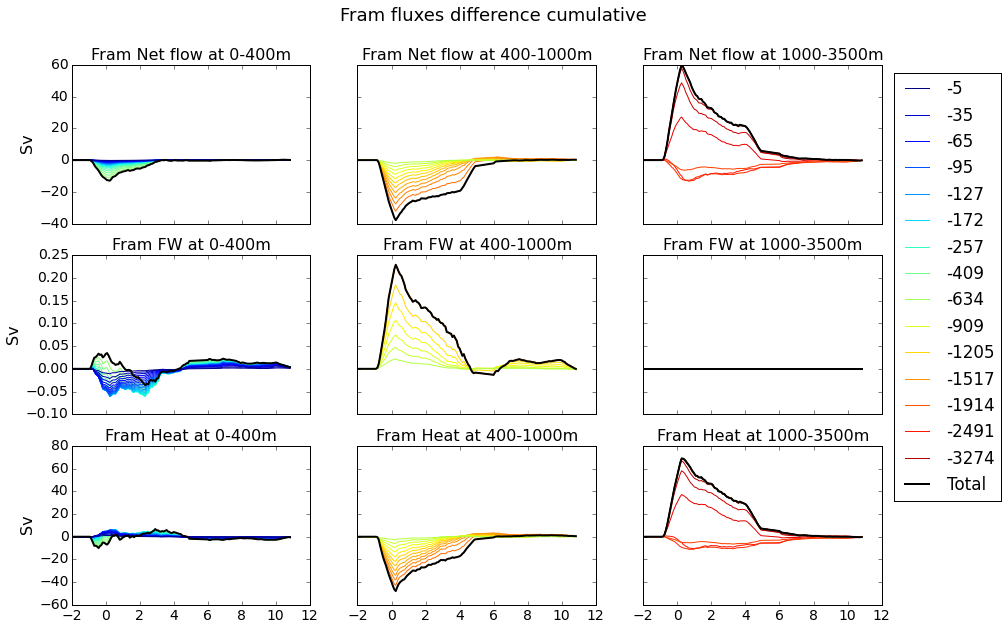

In [17]:
# plot layers
def plot_total_flux1(data_pert,data_diff,cum=True,row=2,col=2):
    # this function is meant to plot monitor variables   
    ax_ind = 0
    fluxes = ['Flux','FluxFW','FluxT']
    #variables = ['Fram','Barents','Davis','Denmark']
    variables = ['Fram','Fram','Fram']
    var_dic = {0:'Fram',1:'Fram',2:'Fram'}
    flux_titles = {'FluxFW' : 'FW','FluxFW1' : 'FW<35','FluxS' : 'S', 'FluxT':'Heat', \
                   'FluxIn' : 'Inflow','FluxOut' : 'Outflow' , 'Flux' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    if cum:
        cumtit = 'cumulative'
        cumtitle = '_cumulative'
    else:
        cumtit = 'per layer'
        cumtitle = '_layer'
    iniz = 36
    depth = {0:'0-400' , 1 : '400-1000' ,2 :'1000-3500'}
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for flux in fluxes:
        ind = 0
        for vard in var_dic:
            var = var_dic[vard]
            colormap = matplotlib.cm.jet
            colors = [colormap(i) for i in np.linspace(0, 1,45)]
            if vard  == 0:
                beg = 0
                end = 24 
            elif vard == 1:
                beg = 24
                end = 36
            else:
                beg = 36
                end = 44
            for k in range(end,beg,-1):    
                if cum:
                    data = np.nansum(np.nansum((data_pert.fluxes[var][flux] -  data_diff.fluxes[var][flux] \
                                               )[:,beg:k,:],axis=2),axis=1)
                else:
                    data = np.nansum((data_pert.fluxes[var][flux] -  data_diff.fluxes[var][flux])[:,k,:],axis=1)
                axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(data,12)[iniz:-1],color=colors[k])
            if cum & (ax_ind != 8):
                axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(np.nansum(np.nansum((
                    data_pert.fluxes[var][flux] -  data_diff.fluxes[var][flux])[:,beg:end,:],axis=2),axis=1),12)
                                   [iniz:-1],color='black',label='Total',lw=2)
            if ax_ind%len(variables)==0:
                axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
            if ax_ind/len(variables)-1==2:
                axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
            axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux] +' at '+ depth[vard]+'m',fontsize=16)
            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
            ax_ind += 1

    for k in range(0,44,3):
        ax_ind = 8
        axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(np.nansum(np.nansum((
                data_pert.fluxes[var][flux] -  data_diff.fluxes[var][flux])[:,beg:end,:],axis=2),axis=1),12)
                                   [iniz:-1],color=colors[k],label=int(data_pert.Z[k]))
    axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(np.nansum(np.nansum((
                data_pert.fluxes[var][flux] -  data_diff.fluxes[var][flux])[:,beg:end,:],axis=2),axis=1),12)
                           [iniz:-1],color='black',label='Total',lw=2)
    plt.legend(bbox_to_anchor=(1.05, 2), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fram fluxes difference "+cumtit,x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/fram_fluxes'+cumtitle,dpi=dpires, bbox_inches='tight')

plot_total_flux1(pert_const,pert_bench,)
#plot_total_flux(pert_const,pert_bench,cum=False)

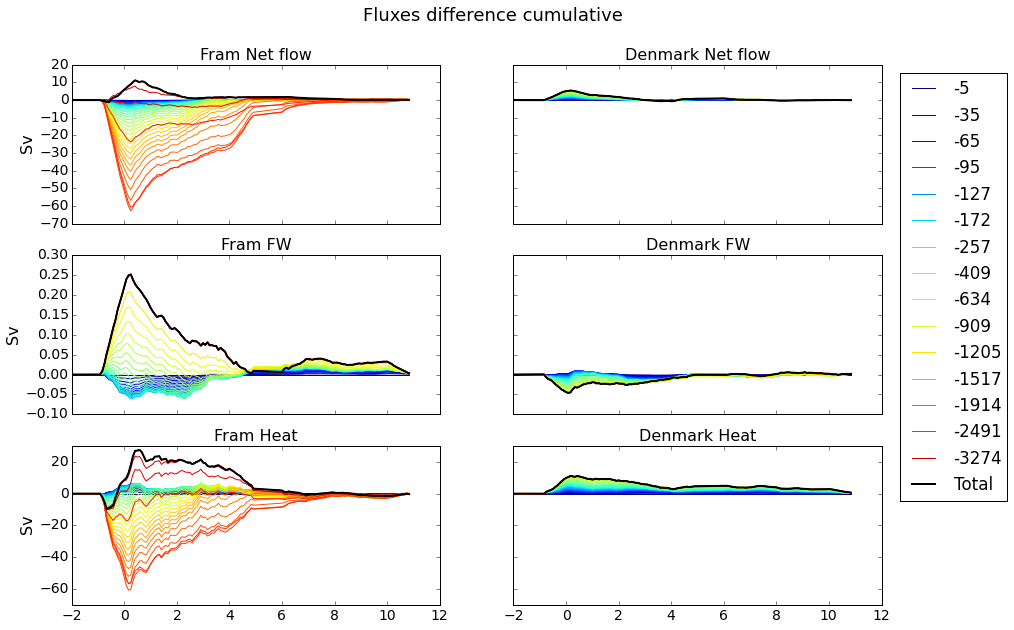

In [18]:
# plot layers
def plot_total_flux(data_pert,data_diff,cum=True,row=2,col=2):
    # this function is meant to plot monitor variables   
    ax_ind = 0
    fluxes = ['Flux','FluxFW','FluxT']
    #variables = ['Fram','Barents','Davis','Denmark']
    variables = ['Fram','Denmark']
    flux_titles = {'FluxFW' : 'FW','FluxFW1' : 'FW<35','FluxS' : 'S', 'FluxT':'Heat', \
                   'FluxIn' : 'Inflow','FluxOut' : 'Outflow' , 'Flux' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    if cum:
        cumtit = 'cumulative'
        cumtitle = '_cumulative'
    else:
        cumtit = 'per layer'
        cumtitle = '_layer'
    iniz = 36
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for flux in fluxes:
        for var in variables:
            colormap = matplotlib.cm.jet
            colors = [colormap(i) for i in np.linspace(0, 1,46)]
            for k in range(0,45,1):
                if cum:
                    data = np.nansum(np.nansum((data_pert.fluxes[var][flux] - data_diff.fluxes[var][flux]\
                                               )[:,0:k,:],axis=2),axis=1)
                else:
                    data = np.nansum((data_pert.fluxes[var][flux] -  data_diff.fluxes[var][flux])[:,k,:],axis=1)

                if (k % 3) == 0 :
                    axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(data,12)[iniz:-1],color=colors[k],\
                                           label=int(data_pert.Z[k]))
                else:
                    axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(data,12)[iniz:-1],color=colors[k])
            if cum:
                axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(np.nansum(np.nansum((
                                data_pert.fluxes[var][flux] - data_diff.fluxes[var][flux] )[:,0:k,:],axis=2),axis=1),12)
                                   [iniz:-1],color='black',label='Total',lw=2)
            if ax_ind%len(variables)==0:
                axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
            if ax_ind/len(variables)-1==2:
                axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
            axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
            ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 2), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference "+cumtit,x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/perturbation_davisfram_fluxes'+cumtitle,dpi=dpires, bbox_inches='tight')

plot_total_flux(pert_const,pert_bench,)
#plot_total_flux(pert_const,pert_bench,cum=False)

Effect on the freshwater transport and freshwater content

# Temperature and salinity evolution

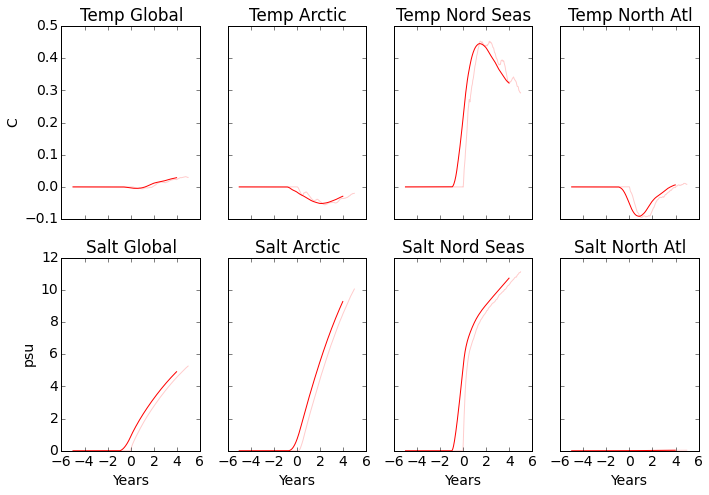

In [287]:
def plot_dynStLayers(data_pert,data_diff,row=2,col=4):
    # this function is meant to plot monitor variables   
    region_titles = reg_titles()
    fig, axes = plt.subplots(row,col,sharex=True,sharey='row')
    ax_ind = 0
    var_s = ['theta_mean','salt_mean']
    vartitles = {'theta_mean' : 'Temp', 'salt_mean' : 'Salt'}
    for var in var_s:
        for reg in range(4):
            data = data_pert.dataDyn[var][1:,reg,0] - data_diff.dataDyn[var][1:len(data_pert.dataDyn[var][1:,reg,0])+1,reg,0]
            axes.flat[ax_ind].plot(data_pert.dataDyn['time_lv_years']-5,data,data_pert.color,alpha=0.2)
            axes.flat[ax_ind].plot(data_pert.dataDyn['time_lv_years'][0:-12*3]-5,\
                               runningMeanFast(data,12*3)[0:-12*3],data_pert.color)
            axes.flat[ax_ind].set_title(vartitles[var]+' '+region_titles[reg])
            axes.flat[0].set_ylabel('C')
            axes.flat[4].set_ylabel('psu')
            axes.flat[4].set_xlabel('Years')
            axes.flat[5].set_xlabel('Years')
            axes.flat[6].set_xlabel('Years')
            axes.flat[7].set_xlabel('Years')
            ax_ind += 1
    fig.subplots_adjust(right=1.6,top=1.6)
plot_dynStLayers(pert_const,pert_bench)

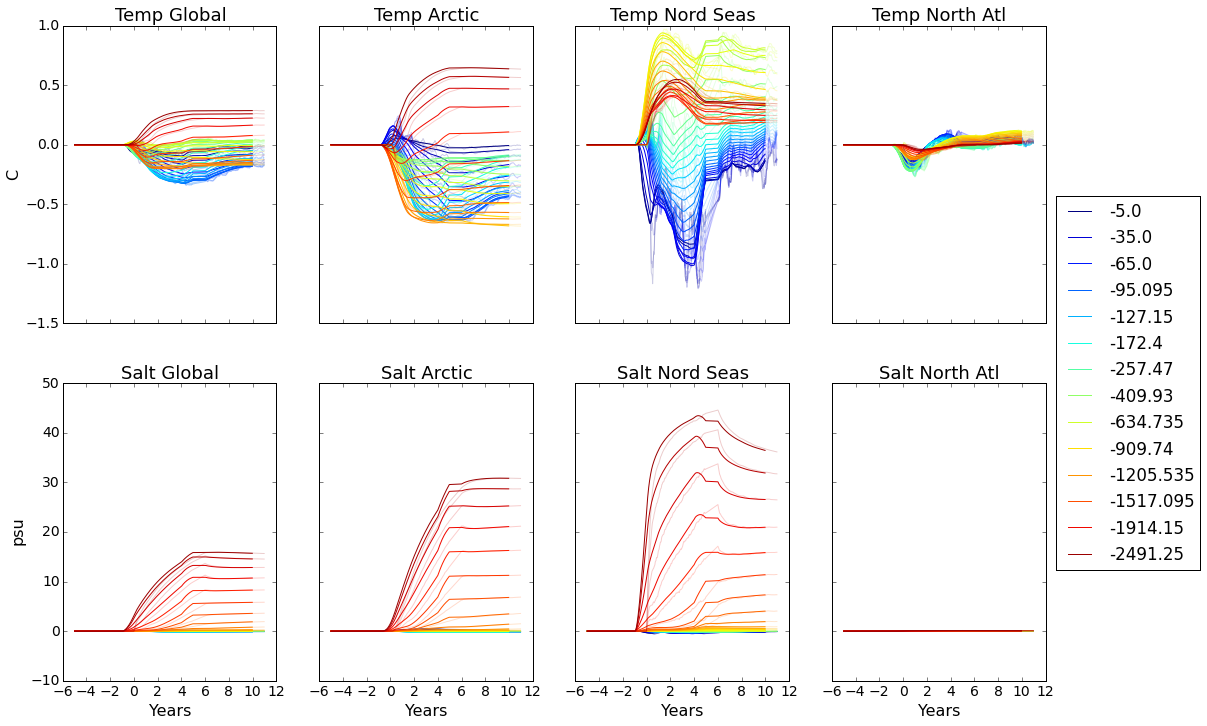

In [19]:
def plot_dynStLayers(data_pert,data_diff,row=2,col=4):
    # this function is meant to plot monitor variables   
    region_titles = reg_titles()
    fig, axes = plt.subplots(row,col,sharex=True,sharey='row')
    ax_ind = 0
    var_s = ['theta_lv_mean','salt_lv_mean']
    vartitles = {'theta_lv_mean' : 'Temp', 'salt_lv_mean' : 'Salt'}
    colormap = matplotlib.cm.jet 
    nz = 40
    colors = [colormap(i) for i in np.linspace(0, 1,nz+1)]
    for var in var_s:
        for reg in range(4):
            for k in range(nz):
                data = data_pert.dataDyn[var][1:,reg,k] - data_diff.dataDyn[var][1:len(data_pert.dataDyn[var][1:,reg,k])+1,reg,k]
                axes.flat[ax_ind].plot(data_pert.dataDyn['time_lv_years']-5,data,color=colors[k],alpha=0.2)
                if k%3 == 0:
                    axes.flat[ax_ind].plot(data_pert.dataDyn['time_lv_years'][0:-12*3]-5,\
                               runningMeanFast(data,12*3)[0:-12*3],color=colors[k],label=data_pert.Z[k])
                else:
                    axes.flat[ax_ind].plot(data_pert.dataDyn['time_lv_years'][0:-12*3]-5,\
                               runningMeanFast(data,12*3)[0:-12*3],color=colors[k])                    
            axes.flat[ax_ind].set_title(vartitles[var]+' '+region_titles[reg],fontsize=18)
            axes.flat[0].set_ylabel('C',fontsize=16)
            axes.flat[4].set_ylabel('psu',fontsize=16)
            axes.flat[4].set_xlabel('Years',fontsize=16)
            axes.flat[5].set_xlabel('Years',fontsize=16)
            axes.flat[6].set_xlabel('Years',fontsize=16)
            axes.flat[7].set_xlabel('Years',fontsize=16)
            ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.4,top=2.4)
plot_dynStLayers(pert_const,pert_bench)

#Freshwater content in Arctic and Nordic Seas

Now we want to study more in the details the changes in freshwater content cause by the perturbation.

Here we consider the freshwater content in the first 1000m of the water column.

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


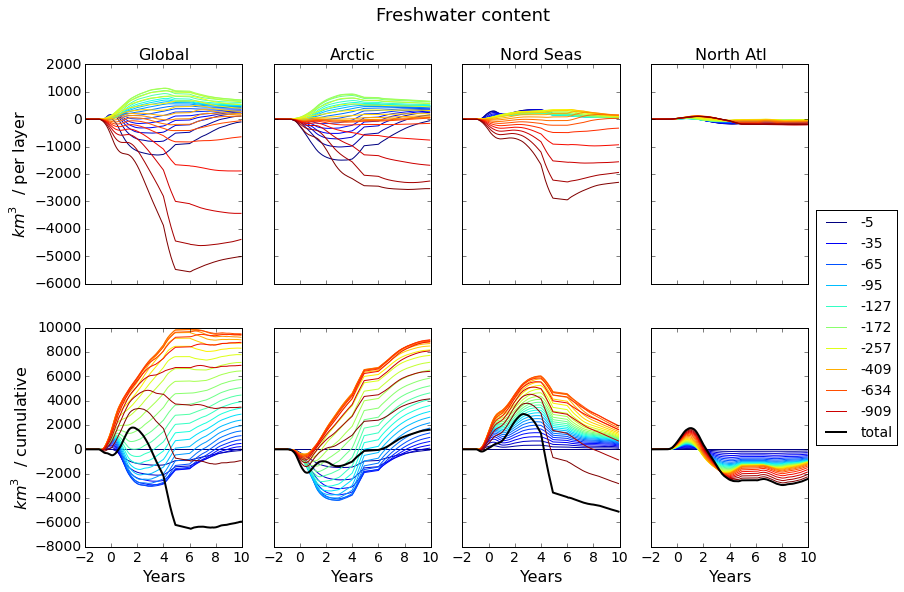

In [20]:
def plot_freshwater_content(data_pert,data_diff):
    titles = reg_titles()
    ls = {'all' : ':' , 'few' : '--'}
    fig , axes = plt.subplots(2,4,sharex=True,sharey='row')
    for j in range(4):        
        nt = len(data_pert.freshwater_levels[j,:])
        colormap = matplotlib.cm.jet 
        colors = [colormap(i) for i in np.linspace(0, 1,30)]
        iniz = 36
        for k in range(0,30):  
            datam = data_pert.freshwater_levels[j,:,0:k] - data_diff.freshwater_levels[j,:nt,0:k]
            datam = np.nansum(datam,axis=1)
            if (k %3 == 0):
                axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k],label=int(data_pert.Z[k]))
            else:
                axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k])
            datam = data_pert.freshwater_levels[j,:,k] - data_diff.freshwater_levels[j,:nt,k]
            if (k%3 == 0):
                axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k],label=int(data_pert.Z[k]))
            else:
                axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k])
        datam = np.nansum(data_pert.freshwater_levels[j,:,0:30] - data_diff.freshwater_levels[j,:nt,0:30],axis=1)                
        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='black',label='total',lw=2)   
        axes.flat[j].set_title(titles[j],fontsize=16)
        
        axes.flat[4].set_ylabel(r'$km^3$ / cumulative',fontsize=16)
        axes.flat[0].set_ylabel(r'$km^3$ / per layer',fontsize=16)
        axes.flat[j+4].set_xlabel('Years',fontsize=16)
        axes.flat[j].tick_params(axis='both', which='major', labelsize=14)
        axes.flat[j+4].tick_params(axis='both', which='major', labelsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.suptitle("Freshwater content ",x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_fw',dpi=dpires, bbox_inches='tight')

plot_freshwater_content(pert_const,pert_bench)

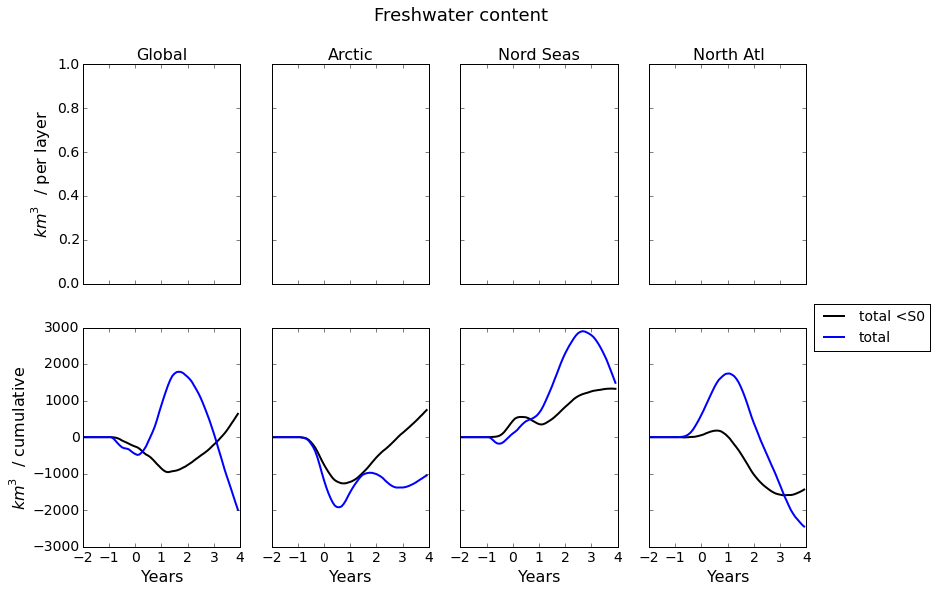

In [48]:
def plot_freshwater_content(data_pert,data_diff):
    titles = reg_titles()
    ls = {'all' : ':' , 'few' : '--'}
    fig , axes = plt.subplots(2,4,sharex=True,sharey='row')
    for j in range(4):        
        nt = len(data_pert.freshwater_levels[j,:])
        colormap = matplotlib.cm.jet 
        colors = [colormap(i) for i in np.linspace(0, 1,30)]
        iniz = 36
        #for k in range(0,30):  
        #    datam = data_pert.freshwater_levels1[j,:,0:k] - data_diff.freshwater_levels1[j,:nt,0:k]
        #    datam = np.nansum(datam,axis=1)
            #if (k %3 == 0):
            #    axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
            #              color=colors[k],label=int(data_pert.Z[k]))
            #else:
            #    axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
            #              color=colors[k])
            #datam = data_pert.freshwater_levels1[j,:,k] - data_diff.freshwater_levels1[j,:nt,k]
            #if (k%3 == 0):
            #    axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
            #              color=colors[k],label=int(data_pert.Z[k]))
            #else:
            #    axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
            #              color=colors[k])
        datam = np.nansum(data_pert.freshwater_levels1[j,:,0:30] - data_diff.freshwater_levels1[j,:nt,0:30],axis=1)                
        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='black',label='total <S0',lw=2)   
        datam = np.nansum(data_pert.freshwater_levels[j,:,0:30] - data_diff.freshwater_levels[j,:nt,0:30],axis=1)                
        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='blue',label='total',lw=2)   
        axes.flat[j].set_title(titles[j],fontsize=16)
        
        axes.flat[4].set_ylabel(r'$km^3$ / cumulative',fontsize=16)
        axes.flat[0].set_ylabel(r'$km^3$ / per layer',fontsize=16)
        axes.flat[j+4].set_xlabel('Years',fontsize=16)
        axes.flat[j].tick_params(axis='both', which='major', labelsize=14)
        axes.flat[j+4].tick_params(axis='both', which='major', labelsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=14)
    fig.suptitle("Freshwater content ",x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_fw',dpi=dpires, bbox_inches='tight')

plot_freshwater_content(pert_const,pert_bench)

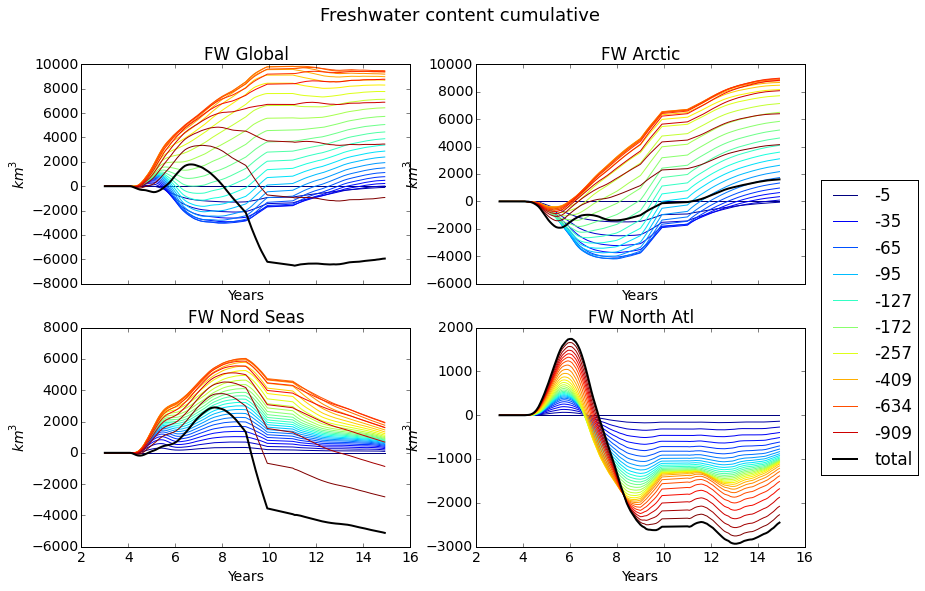

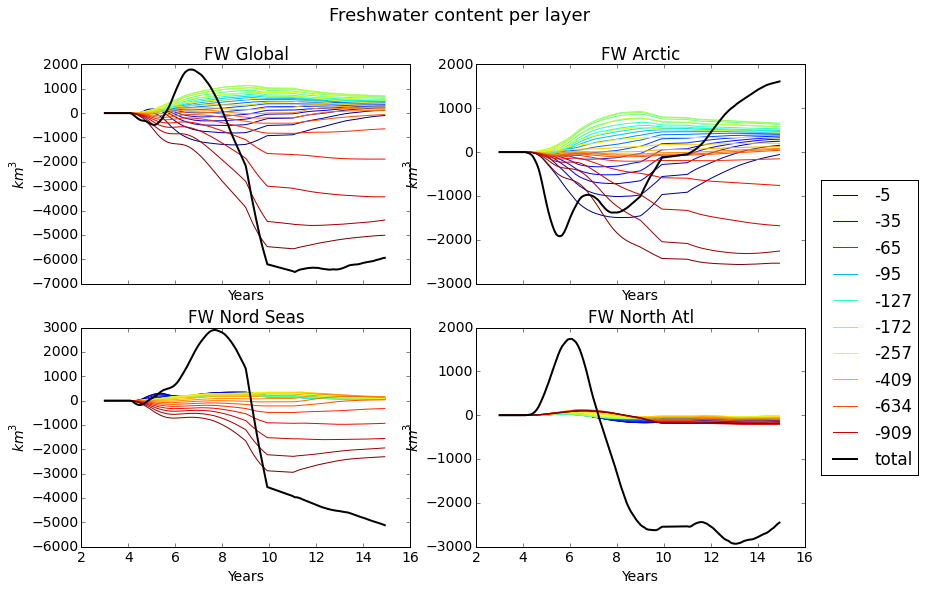

In [21]:
def plot_freshwater_content(data_pert,data_diff,cum=True):
    titles = reg_titles()
    ls = {'all' : ':' , 'few' : '--'}
    fig , axes = plt.subplots(2,2,sharex=True)
    for j in range(4):        
        nt = len(data_pert.freshwater_levels[j,:])
        colormap = matplotlib.cm.jet 
        colors = [colormap(i) for i in np.linspace(0, 1,30)]
        iniz = 36
        if cum:
            cumtit = 'cumulative'
            cumtitle = '_cumulative'
        else:
            cumtit = 'per layer'
            cumtitle = '_layer'
        for k in range(0,30):  
            if cum:                
                datam = data_pert.freshwater_levels[j,:,0:k] - data_diff.freshwater_levels[j,:nt,0:k]
                datam = np.nansum(datam,axis=1)
            else:
                datam = data_pert.freshwater_levels[j,:,k] - data_diff.freshwater_levels[j,:nt,k]

            if (k %3 == 0):
                axes.flat[j].plot(data_pert.years[iniz:-12],runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k],label=int(data_pert.Z[k]))
            else:
                axes.flat[j].plot(data_pert.years[iniz:-12],runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k])
        datam = np.nansum(data_pert.freshwater_levels[j,:,0:30] - data_diff.freshwater_levels[j,:nt,0:30],axis=1)
        axes.flat[j].plot(data_pert.years[iniz:-12],runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='black',label='total',lw=2)
        axes.flat[j].set_title('FW '+titles[j])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
        axes.flat[j].set_ylabel(r'$km^3$')
        axes.flat[j].set_xlabel('Years')
    fig.suptitle("Freshwater content "+cumtit,x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
        
plot_freshwater_content(pert_const,pert_bench)
plot_freshwater_content(pert_const,pert_bench,cum=False)

We see that freshwater content is increasing in the model, this could be caused by an increase in melting of seaice because of heating transported from the Nordic Seas (tested later).

IndexError: index 6 is out of bounds for axis 0 with size 6

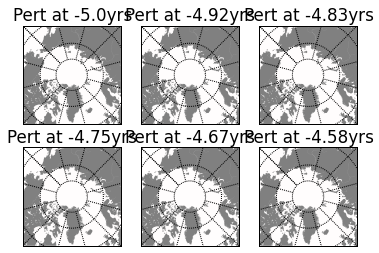

In [293]:
# We plot seaice
def basemap_freshwater(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = -20.0 ; vimax = 20
    fig, axes = plt.subplots(2,3)
    
    depth = np.tile([grid['Zp']],(len(data_pert.X),len(data_pert.Y),1))
    depth = np.swapaxes(depth,0,2) 
    
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_pert.lon,data_pert.lat)

        data = np.array(data_pert.data['S'][t,:,:,:])
        data1 = np.array(data_diff.data['S'][t,:,:,:])    
        datam = np.nansum((1 - data[0:29,:,:]/34.8)*depth[0:29,:,:],axis=0) - \
                np.nansum((1 - data1[0:29,:,:]/34.8)*depth[0:29,:,:],axis=0)
                 
        sitm = datam
        np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolor(x,y,sitm,cmap=matplotlib.cm.seismic,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs')
        ind += 1
    fig.suptitle("Freshwater content top 1000m difference",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu')
    fig.subplots_adjust(right=1.7,top=1.8)    
    
basemap_freshwater(pert_const,pert_bench,times)

## Heat content evolution per layer per region

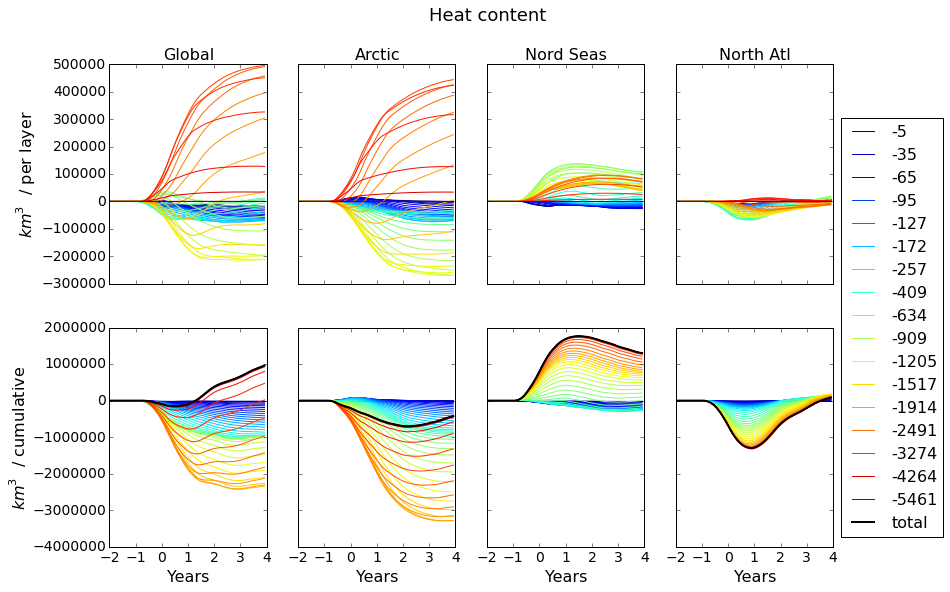

In [294]:
def plot_heat_content(data_pert,data_diff):
    titles = reg_titles()
    ls = {'all' : ':' , 'few' : '--'}
    fig , axes = plt.subplots(2,4,sharex=True,sharey='row')
    for j in range(4):        
        nt = len(data_pert.heat_levels[j,:])
        colormap = matplotlib.cm.jet 
        colors = [colormap(i) for i in np.linspace(0, 1,50)]
        iniz = 36
        for k in range(0,50):  
            datam = data_pert.heat_levels[j,:,0:k] - data_diff.heat_levels[j,:nt,0:k]
            datam = np.nansum(datam,axis=1)
            if (k %3 == 0):
                axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k],label=int(data_pert.Z[k]))
            else:
                axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k])
            datam = data_pert.heat_levels[j,:,k] - data_diff.heat_levels[j,:nt,k]
            if (k%3 == 0):
                axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k],label=int(data_pert.Z[k]))
            else:
                axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k])
        datam = np.nansum(data_pert.heat_levels[j,:,0:50] - data_diff.heat_levels[j,:nt,0:50],axis=1)                
        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='black',label='total',lw=2)   
        axes.flat[j].set_title(titles[j],fontsize=16)
        axes.flat[4].set_ylabel(r'$km^3$ / cumulative',fontsize=16)
        axes.flat[0].set_ylabel(r'$km^3$ / per layer',fontsize=16)
        axes.flat[j+4].set_xlabel('Years',fontsize=16)
        axes.flat[j].tick_params(axis='both', which='major', labelsize=14)
        axes.flat[j+4].tick_params(axis='both', which='major', labelsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=16)
    fig.suptitle("Heat content ",x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)    
    fig.savefig('/noc/users/am8e13/Figures/perturbation_hc',dpi=dpires, bbox_inches='tight')

plot_heat_content(pert_const,pert_bench)

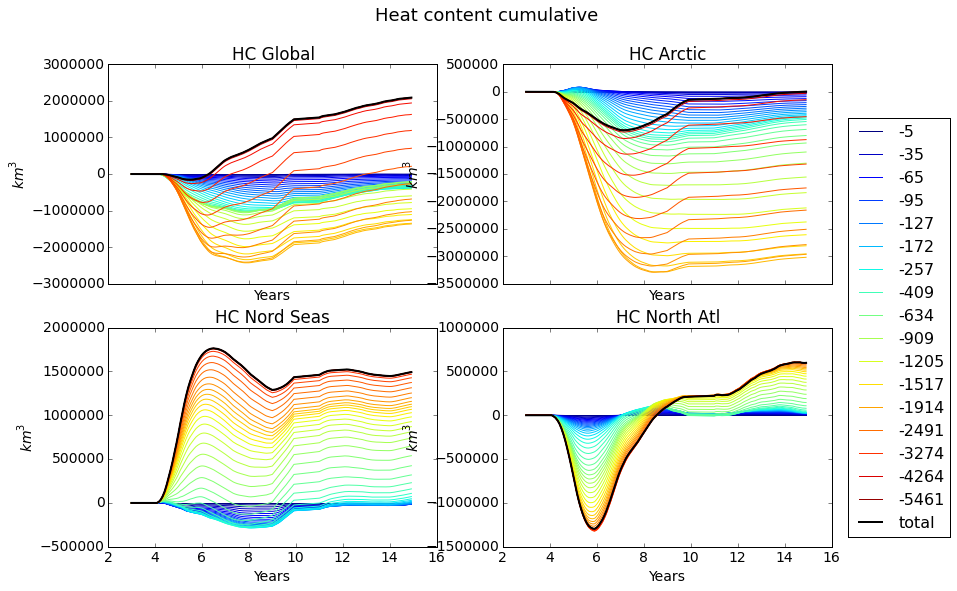

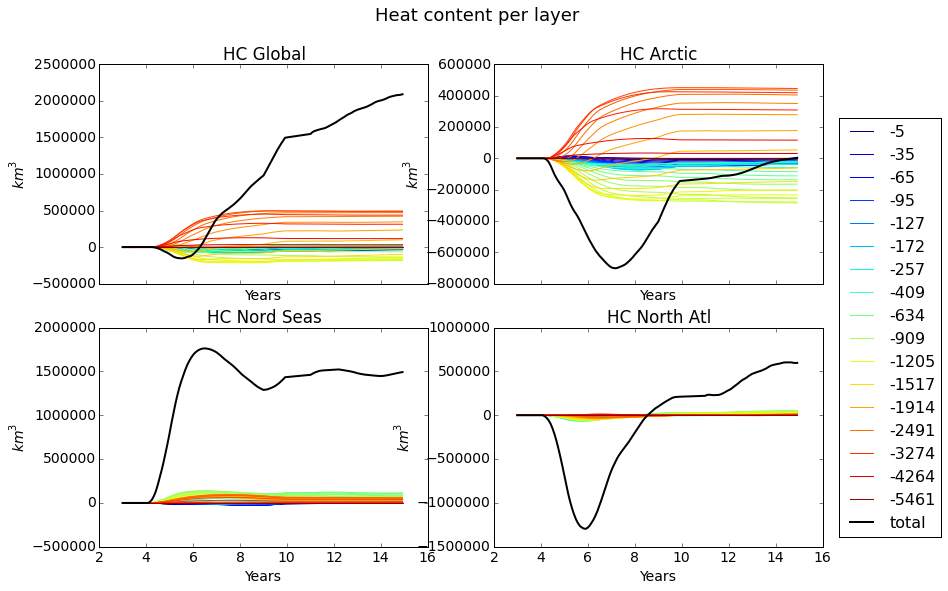

In [22]:
def plot_heat_content(data_pert,data_diff,cum=True):
    titles = reg_titles()
    ls = {'all' : ':' , 'few' : '--'}
    fig , axes = plt.subplots(2,2,sharex=True)
    for j in range(4):        
        nt = len(data_pert.freshwater_levels[j,:])
        colormap = matplotlib.cm.jet 
        colors = [colormap(i) for i in np.linspace(0, 1,50)]
        iniz = 36
        if cum:
            cumtit = 'cumulative'
            cumtitle = '_cumulative'
        else:
            cumtit = 'per layer'
            cumtitle = '_layer'
        for k in range(0,49):  
            if cum:                
                datam = data_pert.heat_levels[j,:,0:k] - data_diff.heat_levels[j,:nt,0:k]
                datam = np.nansum(datam,axis=1)
            else:
                datam = data_pert.heat_levels[j,:,k] - data_diff.heat_levels[j,:nt,k]
                
            if (k %3 == 0):
                axes.flat[j].plot(data_pert.years[iniz:-12],runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k],label=int(data_pert.Z[k]))
            else:
                axes.flat[j].plot(data_pert.years[iniz:-12],runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                          color=colors[k])
        datam = np.nansum(data_pert.heat_levels[j,:,0:49] - data_diff.heat_levels[j,:nt,0:49],axis=1)
        axes.flat[j].plot(data_pert.years[iniz:-12],runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='black',label='total',lw=2)
        axes.flat[j].set_title('HC '+titles[j])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=16)
        axes.flat[j].set_ylabel(r'$km^3$')
        axes.flat[j].set_xlabel('Years')
    fig.suptitle("Heat content "+cumtit,x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
        
plot_heat_content(pert_const,pert_bench)
plot_heat_content(pert_const,pert_bench,cum=False)

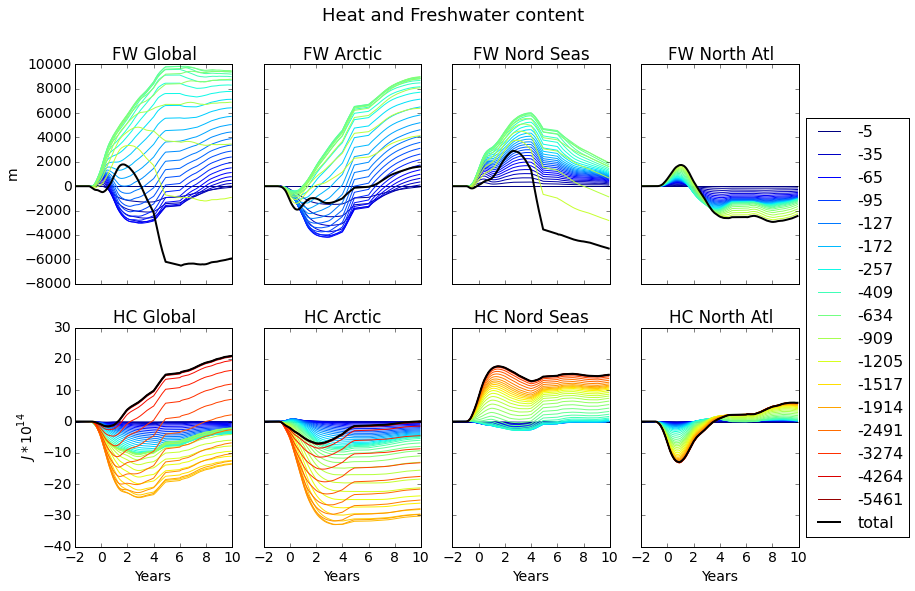

In [23]:
def plot_heat_content(data_pert,data_diff):
    titles = reg_titles()
    fig , axes = plt.subplots(2,4,sharex=True,sharey='row')
    for j in range(4):        
        nt = len(data_pert.freshwater_levels[j,:])
        colormap = matplotlib.cm.jet 
        colors = [colormap(i) for i in np.linspace(0, 1,50)]
        iniz = 36
        for k in range(0,49):             
            datam = data_pert.freshwater_levels[j,:,0:k] - data_diff.freshwater_levels[j,:nt,0:k]
            datam = np.nansum(datam,axis=1) 
            if (k < 30):
                axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                      color=colors[k])
                
            datam = data_pert.heat_levels[j,:,0:k] - data_diff.heat_levels[j,:nt,0:k]
            datam = np.nansum(datam,axis=1)
            if (k %3 == 0):
                axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**14,
                          color=colors[k],label=int(data_pert.Z[k]))
            else:
                axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**14,
                          color=colors[k])
        datam = np.nansum(data_pert.freshwater_levels[j,:,0:30] - data_diff.freshwater_levels[j,:nt,0:30],axis=1)
        axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='black',lw=2)                                
        
        datam = np.nansum(data_pert.heat_levels[j,:,0:49] - data_diff.heat_levels[j,:nt,0:49],axis=1)
        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**14,
                        color='black',label='total',lw=2)
            
        axes.flat[j].set_title('FW '+titles[j])
        axes.flat[j+4].set_title('HC '+titles[j])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=16)
        axes.flat[0].set_ylabel('m')
        axes.flat[4].set_ylabel(r'$J*10^{14}$')
        axes.flat[j+4].set_xlabel('Years')
    fig.suptitle("Heat and Freshwater content ",x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_hcfw',dpi=dpires, bbox_inches='tight')
        
plot_heat_content(pert_const,pert_bench)
#plot_heat_content(pert_const,pert_bench)

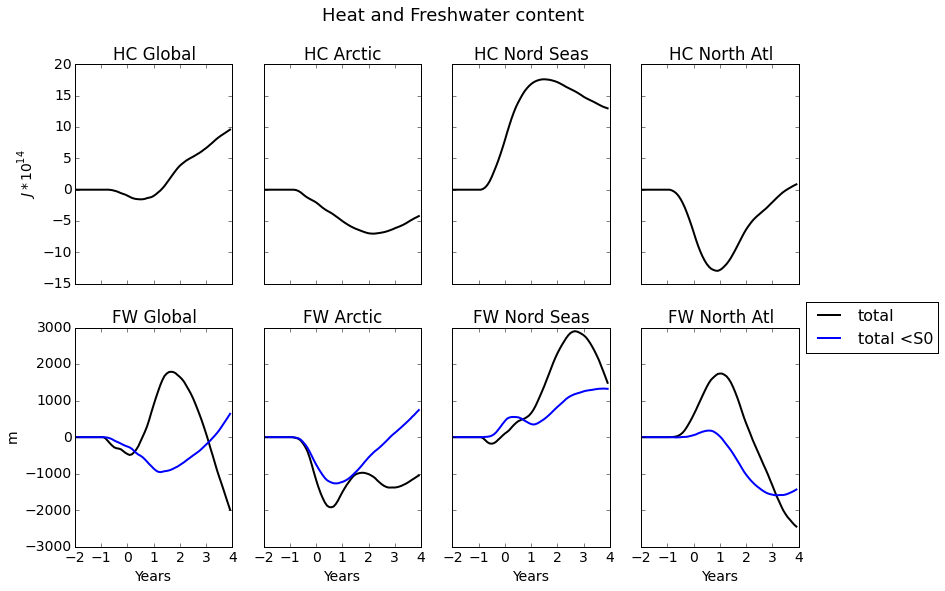

In [54]:
def plot_heat_content(data_pert,data_diff):
    titles = reg_titles()
    fig , axes = plt.subplots(2,4,sharex=True,sharey='row')
    for j in range(4):        
        nt = len(data_pert.freshwater_levels[j,:])
        colormap = matplotlib.cm.jet 
        colors = [colormap(i) for i in np.linspace(0, 1,50)]
        iniz = 36
        #for k in range(0,49):             
        #    datam = data_pert.freshwater_levels[j,:,0:k] - data_diff.freshwater_levels[j,:nt,0:k]
        #    datam = np.nansum(datam,axis=1) 
        #    if (k < 30):
        #        axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
        #              color=colors[k])
        #        
        #    datam = data_pert.heat_levels[j,:,0:k] - data_diff.heat_levels[j,:nt,0:k]
        #    datam = np.nansum(datam,axis=1)
        #    if (k %3 == 0):
        #        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**14,
        #                  color=colors[k],label=int(data_pert.Z[k]))
        #    else:
        #        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**14,
        #                  color=colors[k])        
        datam = np.nansum(data_pert.heat_levels[j,:,0:49] - data_diff.heat_levels[j,:nt,0:49],axis=1)
        axes.flat[j].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**14,
                        color='black',label='total',lw=2)
        datam = np.nansum(data_pert.freshwater_levels[j,:,0:30] - data_diff.freshwater_levels[j,:nt,0:30],axis=1)
        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='black',label='total',lw=2) 
        datam = np.nansum(data_pert.freshwater_levels1[j,:,0:30] - data_diff.freshwater_levels1[j,:nt,0:30],axis=1)
        axes.flat[j+4].plot(data_pert.years[iniz:-12]-5,runningMeanFast(datam[iniz:],12)[0:-12]/10**9,
                        color='blue',label='total <S0',lw=2)             
        
        axes.flat[j+4].set_title('FW '+titles[j])
        axes.flat[j].set_title('HC '+titles[j])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=16)
        axes.flat[4].set_ylabel('m')
        axes.flat[0].set_ylabel(r'$J*10^{14}$')
        axes.flat[j+4].set_xlabel('Years')
    fig.suptitle("Heat and Freshwater content ",x=1.,y=2.,fontsize=18)      
    fig.subplots_adjust(right=1.8,top=1.8)
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_hcfw',dpi=dpires, bbox_inches='tight')
        
plot_heat_content(pert_const,pert_bench)
#plot_heat_content(pert_const,pert_bench)

In [ ]:
# We plot seaice
def basemap_tempdiff(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    vimin = -1 ; vimax = 1
    fig, axes = plt.subplots(2,3)
    
    depth = np.tile([grid['Zp']],(len(data_pert.X),len(data_pert.Y),1))
    depth = np.swapaxes(depth,0,2) 
    
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_pert.lon,data_pert.lat)

        data = np.array(data_pert.data['T'][t,:,:,:])
        data1 = np.array(data_diff.data['T'][t,:,:,:])    
        datam = np.nansum(data*depth,axis=0)/np.abs(data_pert.Z[49])-np.nansum(data1*depth,axis=0)/np.abs(data_pert.Z[49])
        #datam = np.nansum(data,axis=0) - np.nansum(data1,axis=0)        
        
        sitm = datam
        np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolor(x,y,sitm,cmap=matplotlib.cm.seismic,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs')
        ind += 1
    fig.suptitle("Temperature difference",x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu')
    fig.subplots_adjust(right=1.7,top=1.8)    
    
basemap_tempdiff(pert_const,pert_bench,times)

# Seaice

We look at the seaice to see if the excess in freshwater could be caused by a decrease in seaice

IndexError: index 6 is out of bounds for axis 0 with size 6

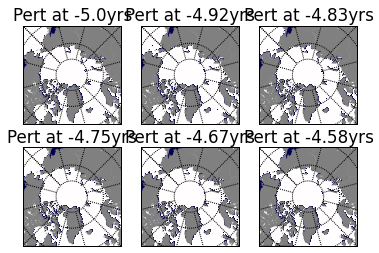

In [226]:
def basemap_seaice_diff(data_pert,data_diff,var,times):
    vimind = {'SIheff' : -3, 'SIarea' : -1 , 'SIhsnow' : -0.5 , 'SIhsalt' : -32973}
    vimaxd = {'SIheff' : 3, 'SIarea' : 1, 'SIhsnow' : 0.5, 'SIhsalt' : 32973}
    titlesd = {'SIheff' : "Seaice ice thickness", 'SIarea' : "Seice area fraction", \
               'SIhsnow' : "Seaice snow thickness", 'SIhsalt' :"Freshwater content difference" }

    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=7000000. ; height=7000000.0
    ind = 0
    fig, axes = plt.subplots(2,3)
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_pert.lon,data_pert.lat)
        datam = data_pert.seaice[var][t,:,:] - data_diff.seaice[var][t,:,:]
        sitm = datam 
        np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=matplotlib.cm.seismic,vmin=vimind[var],vmax=vimaxd[var])
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.years[t]-5,2))+'yrs')
        ind += 1
    fig.suptitle(titlesd[var],x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu')
    fig.subplots_adjust(right=1.7,top=1.8)  
    fig.savefig('/noc/users/am8e13/Figures/perturbation_'+var,dpi=dpires, bbox_inches='tight')

    
basemap_seaice_diff(pert_const,pert_bench,'SIheff',times)
basemap_seaice_diff(pert_const,pert_bench,'SIarea',times)
basemap_seaice_diff(pert_const,pert_bench,'SIhsnow',times)
basemap_seaice_diff(pert_const,pert_bench,'SIhsalt',times)

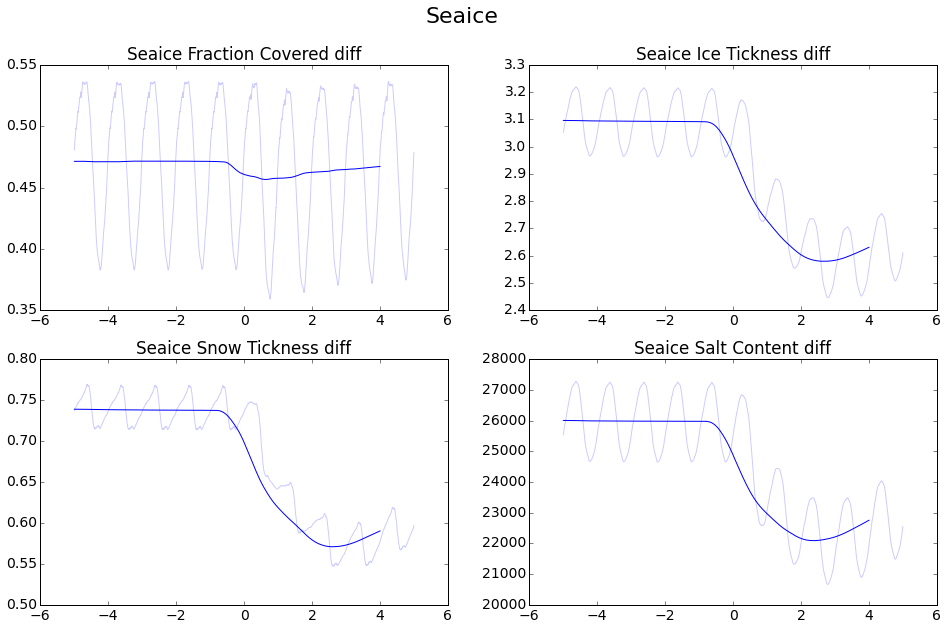

In [396]:
def plot_seaice(data_pert,data_diff):
    variables = ['seaice_area_mean' , 'seaice_heff_mean','seaice_hsnow_mean','seaice_hsalt_mean']
    titles = {'seaice_area_mean' : 'Seaice Fraction Covered', 'seaice_heff_mean' : 'Seaice Ice Tickness',
              'seaice_hsnow_mean' : 'Seaice Snow Tickness', 'seaice_hsalt_mean' : 'Seaice Salt Content'}
    fig , axes = plt.subplots(2,2)
    nt = len(data_diff.data['time_years_ice'])
    for j in range(4):  
        data = data_pert.data[variables[j]][0:nt] #- data_diff.data[variables[j]][0:nt]        
        axes.flat[j].plot(data_diff.data['time_years_ice']-5,data,alpha=0.2,color='b')
        axes.flat[j].plot(data_diff.data['time_years_ice'][0:-360]-5,runningMeanFast(data,360)[0:-360],color='b')
        axes.flat[j].set_title(titles[variables[j]]+' diff')   
    fig.suptitle('Seaice',x=1.1,y=2.2,fontsize=22)
    fig.subplots_adjust(right=2.2,top=2.)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_seiace_diag',dpi=dpires, bbox_inches='tight')

plot_seaice(pert_const,pert_bench)

# Mixed layer depth

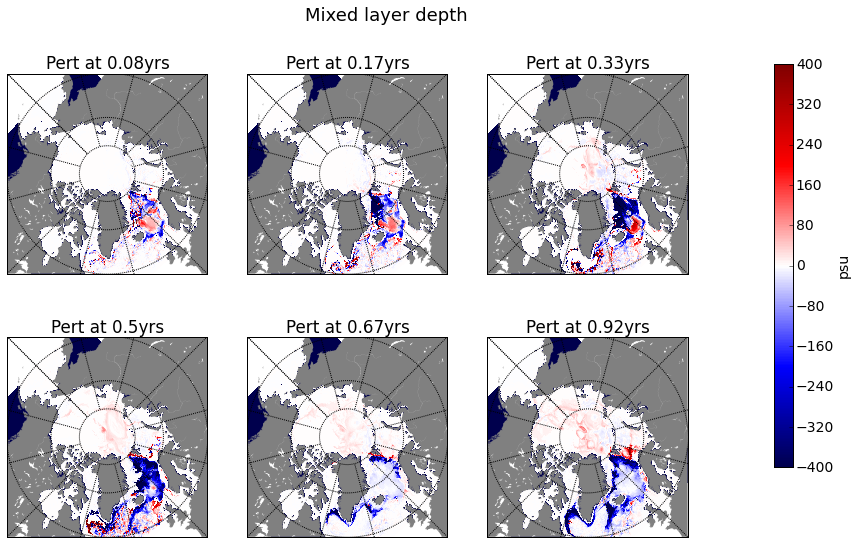

In [135]:
timesmx = [3+12*15, 6+12*15, 12+12*15, 18+12*15,24+12*15,33+12*15]

def basemap_mxldepth(data_pert,data_diff,times):
    lat_ts=90.0 ; lat_0=90.0 ; lon_0=-45.0 ;sgn=1
    width=8000000. ; height=8000000.0
    ind = 0
    vimin = -400 ; vimax = 400
    fig, axes = plt.subplots(2,3)
    for t in times:
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='white')
        x,y=m(data_pert.lon,data_pert.lat)
        datam = data_pert.mxldepth[t,:,:] - data_diff.mxldepth[t,:,:]
        sitm = datam 
        np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolor(x,y,sitm,cmap=matplotlib.cm.seismic,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(round(data_pert.mxldepth_years[t]-5,2))+'yrs')
        ind += 1
    fig.suptitle('Mixed layer depth',x=1.,y=2.,fontsize=18)
    cbar_ax = fig.add_axes([1.9, 0.4, 0.045, 1.4])
    cbar = plt.colorbar(CS, cax=cbar_ax,)
    cbar.ax.set_ylabel(r'psu')
    fig.subplots_adjust(right=1.7,top=1.8)   
    fig.savefig('/noc/users/am8e13/Figures/perturbation_mxldepth_basemap',dpi=dpires, bbox_inches='tight')

basemap_mxldepth(pert_const,pert_bench,timesmx)

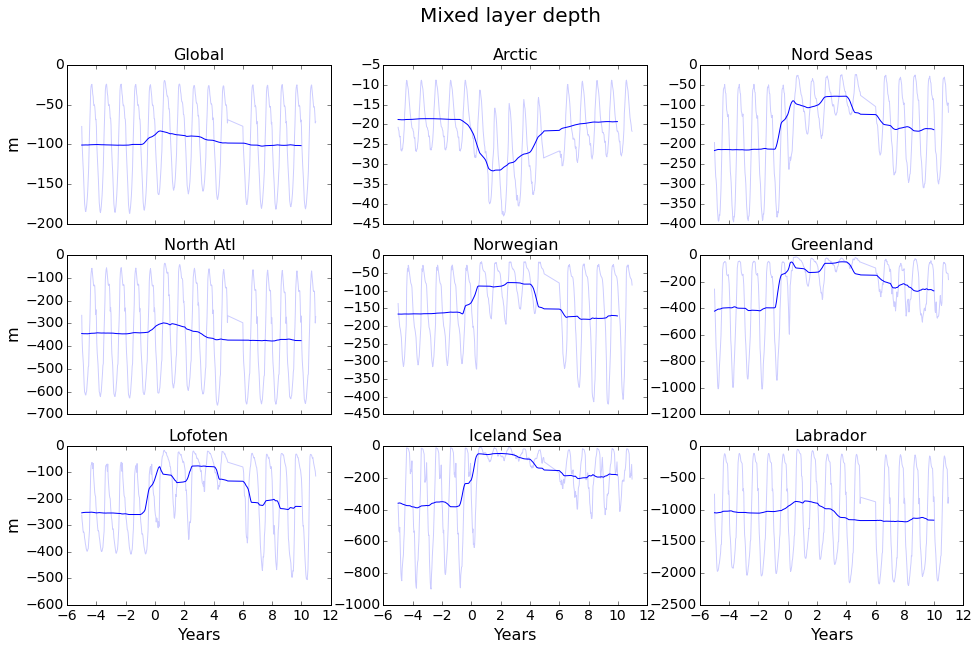

In [24]:
def plot_mxldepth(data_pert,data_diff):
    reg_title = reg_titles()
    fig , axes = plt.subplots(3,3,sharey=False,sharex=True)
    for j in range(len(reg_title)):
#        data = data_pert.mxldepth_mean[j]
#        axes.flat[j].plot(data_pert.mxldepth_years,data,alpha=0.2,color='b')
#        axes.flat[j].plot(data_pert.mxldepth_years[0:-12],runningMeanFast(data,12)[0:-12],color='b')
#        axes.flat[j].set_title(reg_title[j])   
        
        data = data_pert.mxldepth_mean[j] #- data_diff.mxldepth_mean[j]
        axes.flat[j].plot(data_pert.mxldepth_years-5,-data,alpha=0.2,color='b')
        axes.flat[j].plot(data_pert.mxldepth_years[0:-12*3]-5,-runningMeanFast(data,12*3)[0:-12*3],color='b')
        axes.flat[j].set_title(reg_title[j],fontsize=16)   
    #plt.delaxes(axes.flat[9])
    #axes.flat[5].set_xlabel('Years',fontsize=16)
    axes.flat[6].set_xlabel('Years',fontsize=16)
    axes.flat[7].set_xlabel('Years',fontsize=16)
    axes.flat[8].set_xlabel('Years',fontsize=16)
    axes.flat[0].set_ylabel('m',fontsize=16)
    axes.flat[3].set_ylabel('m',fontsize=16)
    axes.flat[6].set_ylabel('m',fontsize=16)

    fig.subplots_adjust(right=2.2,top=2.)
    fig.suptitle("Mixed layer depth",x=1.15,y=2.2,fontsize=20)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_mxldepth_diag',dpi=dpires, bbox_inches='tight')

plot_mxldepth(pert_const,pert_bench)

# Overflow

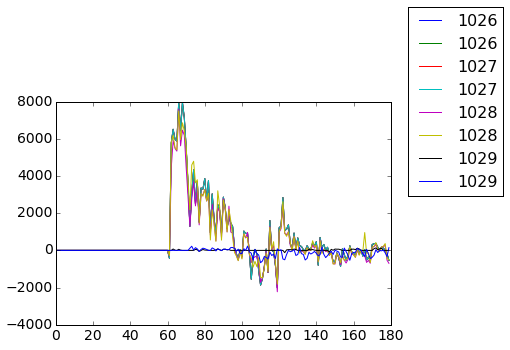

In [25]:
def plot_overflow(run_pert,run_diff):
    kdic = {36:1,18:2,9:4}
    kk = kdic[run_pert.res]
    for rho0 in np.arange(1026,1030,1):
        data = (run_pert.fluxes['Denmark']['Flux']*run_pert.data['rhop'][:,:,100*kk,37*kk:48*kk] - \
               run_diff.fluxes['Denmark']['Flux']*run_diff.data['rhop'][:,:,100*kk,37*kk:48*kk])*\
                (run_diff.data['rhop'][:,:,100*kk,37*kk:48*kk]>rho0)
        datam = np.nansum(np.nansum(data,axis=1),axis=1)
        plt.plot(datam,label=rho0)
        
        data = (run_pert.fluxes['Denmark']['Flux']*run_pert.data['rhop'][:,:,100*kk,37*kk:48*kk] - \
               run_diff.fluxes['Denmark']['Flux']*run_diff.data['rhop'][:,:,100*kk,37*kk:48*kk])*\
                (run_pert.data['rhop'][:,:,100*kk,37*kk:48*kk]>rho0)
        datam = np.nansum(np.nansum(data,axis=1),axis=1)
        plt.plot(datam,label=rho0)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.,fontsize=16)    
plot_overflow(pert_const,pert_bench)

<matplotlib.colorbar.Colorbar instance at 0x2afff8d31ea8>

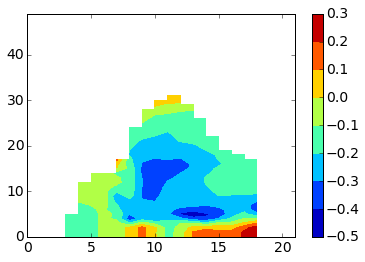

In [188]:
kk = 2
np = 80
plt.contourf(pert_const.data['rhop'][np,:,100*kk,37*kk:48*kk] - pert_bench.data['rhop'][np,:,100*kk,37*kk:48*kk])
plt.colorbar()

In [ ]:
plot_lv(pert_100,'theta_lv_mean',1,-1,7,cmocean.cm.temperature)

In [ ]:
plot_lv(pert_100,'salt_lv_mean',0,32,37,cmocean.cm.salinity)
#plot_lv(pert_70,'salt_lv_mean',0,32,37,cmocean.cm.salinity)

In [ ]:
plot_lv(pert_100,'rho_lv_mean',0,1026,1040,cmocean.cm.density)
#plot_lv(pert_70,'rho_lv_mean',0,1026,1040,cmocean.cm.density)

In [ ]:
plot_lv(pert_100,'ke_lv_mean',0,0,0.05,cmocean.cm.chlorophyll)
#plot_lv(pert_70,'ke_lv_mean',0,0,0.05,cmocean.cm.chlorophyll)

In [ ]:
plot_lv(pert_100,'uvel_lv_mean',0,-0.01,0.01,cmocean.cm.velocity)
#plot_lv(pert_70,'uvel_lv_mean',0,-0.01,0.01,cmocean.cm.velocity)

In [ ]:
plot_lv(pert_100,'vvel_lv_mean',0,-0.01,0.01,cmocean.cm.velocity)
#plot_lv(pert_70,'vvel_lv_mean',0,-0.01,0.01,cmocean.cm.velocity)

In [ ]:
plot_dynSt(pert_100,['salt_mean','salt_max','ke_mean','theta_mean','theta_max','ke_vol'],'all')
#plot_dynSt(pert_100,['vvel_mean','vvel_max','vvel_min','uvel_mean','uvel_max','uvel_min'],'all')

In [ ]:
plot_dynSt(pert_100,['salt_mean','salt_max','ke_mean','theta_mean','theta_max','ke_vol'],0)
#plot_dynSt(pert_100,['vvel_mean','vvel_max','vvel_min','uvel_mean','uvel_max','uvel_min'],0)

In [ ]:
plot_dynSt(pert_100,['salt_mean','salt_max','ke_mean','theta_mean','theta_max','ke_vol'],1)
#plot_dynSt(pert_100,['vvel_mean','vvel_max','vvel_min','uvel_mean','uvel_max','uvel_min'],1)

In [ ]:
plot_dynSt(pert_100,['salt_mean','salt_max','ke_mean','theta_mean','theta_max','ke_vol'],2)
#plot_dynSt(pert_100,['vvel_mean','vvel_max','vvel_min','uvel_mean','uvel_max','uvel_min'],2)

In [ ]:
plot_dynSt(pert_100,['salt_mean','salt_max','ke_mean','theta_mean','theta_max','ke_vol'],3)
#plot_dynSt(pert_100,['vvel_mean','vvel_max','vvel_min','uvel_mean','uvel_max','uvel_min'],3)

In [ ]:
#plot_psi(pert_100,-1,7,matplotlib.cm.jet)

In [ ]:
plot_mxldepth(pert_100,0)
plot_mxldepth(pert_100,1)
plot_mxldepth(pert_100,2)
plot_mxldepth(pert_100,3)

In [ ]:
pert = {0 : pert_const , 1 : pert_bench}

In [ ]:
varlist = ['Fram1' , 'Bering' , 'Barents1','Davis1','Denmark','Norwice']
plot_flux_in_out(pert,varlist,'FluxSum',row=2,col=3)

In [ ]:
varlist = ['Fram1' , 'Bering' , 'Barents1','Davis1','Denmark','Norwice']
plot_flux(pert,varlist,'FluxSum')

In [ ]:
plot_flux(pert,varlist,'FluxInSum')

In [ ]:
plot_flux(pert,varlist,'FluxOutSum')

In [ ]:
plot_flux(pert,varlist,'FluxSumS')

In [ ]:
plot_flux(pert,varlist,'FluxSumT')

In [ ]:
plot_flux(pert,varlist,'FluxSumFW')

In [ ]:
varlist = ['Fram1' , 'Bering' , 'Barents1','Davis1','Denmark','Norwice']
plot_flux_total(pert,varlist,row=2,col=3)

In [ ]:
# this plots the sums of various flows
def plot_total_flux(monitor_list,var_list,flux,row=2,col=2):
    # this function is meant to plot monitor variables   
    fig, axes = plt.subplots(row,col)
    ax_ind = 0
    for mon in monitor_list:
        sumtoplot = 0
        for var in var_list:
            sumtoplot = sumtoplot + monitor_list[mon].fluxes[var][flux]
        
        
            axes.flat[ax_ind].plot(monitor_list[mon].fluxes['years'],sumtoplot,\
                                monitor_list[mon].color,alpha=0.3)
            
            axes.flat[ax_ind].plot(monitor_list[mon].fluxes['years'][0:-12],\
                    runningMeanFast(sumtoplot,12)[0:-12],\
                               monitor_list[mon].color,label = monitor_list[mon].title)
        axes.flat[ax_ind].set_title(monitor_list[mon].title)
        axes.flat[ax_ind].set_ylabel('Sv')
        axes.flat[ax_ind].set_xlabel('Yers')
        ax_ind += 1
    #plt.legend(bbox_to_anchor=(-2.5, 1.02, 2., 1.5),
    #               ncol=4, mode="expand", borderaxespad=0.)
    fig.subplots_adjust(right=2.4,top=2.4)

plot_total_flux(pert_100,varlist,'FluxSum')

In [ ]:
grid = grid_read(36)

In [ ]:
def interact(field,cmap1,vimin1,vimin2,vimax1,vimax2,time1,time2):
    def plot_field2(vimin=1,vimax=20,time=0,Z=0):
        # This function plots a 2D field, the field is meant to have NaNs on the land place                                                
        # vimin is the minimun, vimax is the maximum, setbad is the NaN color, unity is the unity in the colorbar                          
        # cmap is a colomap                                                                                                               
        fig,axes = plt.subplots(1,1)
        masked_array = np.ma.array(field[time,Z,:,:], mask=np.isnan(field[time,Z,:,:]))
        cmap= cmap1
        cmap.set_bad('grey',1.)
        ca = plt.imshow(masked_array,vmin = vimin, vmax = vimax, interpolation='nearest',\
                                       cmap = cmap ,origin="left",aspect='auto')
        ca = plt.pcolor(pert_const.X,pert_const.Y,masked_array,vmin = vimin, vmax = vimax,cmap = cmap)
        cbar = fig.colorbar(ca )
        fig.subplots_adjust(right=2.4,top=2)
        return plot_field2
        
    w = interactive(plot_field2,vimin=(vimin1,vimin2),vimax=(vimax1,vimax2),time=(time1,time2),Z=(time1,time2))
    display(w)
interact(pert_const.ptracers['nordicseas_50m'][:,:,:,:],matplotlib.cm.hot,-1,0,0,100,time1=0,time2=50)

In [ ]:
# this function plots different angles of ptracers                                                                                  
def plot_ptracer(data,ptracer,timings):
    ax_ind = 0
    col = 3
    row = len(timings)
    fig, axes = plt.subplots(row,col)
    vimin = 0.1
    vimax = 100

    cmap= matplotlib.cm.hot
    cmap.set_bad('grey',1.)

    for t in timings:
        masked_array = np.ma.array(np.nanmean(data.ptracers[ptracer][t,:,:,:],axis=0),\
                                   mask=np.isnan(np.nanmean(data.ptracers[ptracer][t,:,:,:],axis=0)))
        ca = axes.flat[ax_ind*col ].imshow(masked_array,vmin = vimin, vmax = vimax, interpolation='nearest',\
                                       cmap = cmap ,origin="left",aspect='auto',norm = matplotlib.colors.LogNorm())

        masked_array = np.ma.array(np.nanmean(data.ptracers[ptracer][t,:,:,0:200],axis=1),\
                                   mask=np.isnan(np.nanmean(data.ptracers[ptracer][t,:,:,0:200],axis=1)))
        ca = axes.flat[ax_ind*col +1].pcolormesh(data.X[0:200],data.Z,masked_array,vmin = vimin, vmax = vimax,cmap=cmap,
                                                 norm = matplotlib.colors.LogNorm())
        axes.flat[ax_ind*col+1].set_title("Perturbation "+ptracer+" after "+str(round(data.ptracers['years'][t],2))+" years")

        masked_array = np.ma.array(np.nanmean(data.ptracers[ptracer][t,:,:,:],axis=2),\
                                   mask=np.isnan(np.nanmean(data.ptracers[ptracer][t,:,:,:],axis=2)))
        ca = axes.flat[ax_ind*col + 2].pcolormesh(data.Y,data.Z,masked_array,vmin = vimin, vmax = vimax, cmap=cmap,
                                              norm = matplotlib.colors.LogNorm())
        cbar = fig.colorbar(ca , ax=axes.flat[ax_ind*col + 2])

        ax_ind += 1
    fig.subplots_adjust(right=2.4,top=5.8)


In [ ]:
pert_iter = [0 + 10 ,2+ 10,6+ 10,9+ 10,19+ 10]

In [ ]:
plot_ptracer(pert_const,'perturbation',pert_iter )

In [ ]:
plot_ptracer(pert_const,'nordicseas_50m',pert_iter)

In [ ]:
plot_ptracer(pert_const,'nordicseas_1_500m',pert_iter )

In [ ]:
plot_ptracer(pert_const,'nordicseas_600_800m',pert_iter )

In [ ]:
plot_ptracer(pert_const, 'arctic_50m',pert_iter)

In [ ]:
plot_ptracer(pert_const,'arctic_1_500m',pert_iter )

In [ ]:
plot_ptracer(pert_const,'arctic_600_800m' ,pert_iter)

In [ ]:
plot_ptracer(pert_const,'fram',pert_iter )

In [ ]:
plot_ptracer(pert_const,'davis',pert_iter )

In [ ]:
# this function plots different angles of ptracers
def plot_ptracer_diff_bench(data,data_diff,ptracer,timings):
    ax_ind = 0
    col = 3
    row = len(timings)
    fig, axes = plt.subplots(row,col)
    vimin = 0.1
    vimax = 100
    
    cmap= matplotlib.cm.hot
    cmap.set_bad('grey',1.)
    
    diff = data.ptracers[ptracer][:,:,:,:]-data_diff.ptracers[ptracer][:,:,:,:]
    diff[diff<0.001] = 0.001
    
    for t in timings:
        masked_array = np.ma.array(np.nanmean(diff[t,:,:,:],axis=0),\
                                   mask=np.isnan(np.nanmean(data.ptracers[ptracer][t,:,:,:],axis=0)))
        ca = axes.flat[ax_ind*col ].imshow(masked_array,vmin = vimin, vmax = vimax, interpolation='nearest',\
                                       cmap = cmap ,origin="left",aspect='auto',norm = matplotlib.colors.LogNorm())

        masked_array = np.ma.array(np.nanmean(diff[t,:,:,0:200],axis=1),\
                                   mask=np.isnan(np.nanmean(data.ptracers[ptracer][t,:,:,0:200],axis=1)))
        ca = axes.flat[ax_ind*col +1].pcolormesh(data.X[0:200],data.Z,masked_array,vmin = vimin, vmax = vimax,\
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())
        axes.flat[ax_ind*col+1].set_title("Perturbation "+ptracer+" after "+str(round(data.ptracers['years'][t],2))+" years")
        
        masked_array = np.ma.array(np.nanmean(diff[t,:,:,:],axis=2),\
                                   mask=np.isnan(np.nanmean(data.ptracers[ptracer][t,:,:,:],axis=2)))
        ca = axes.flat[ax_ind*col + 2].pcolormesh(data.Y,data.Z,masked_array,vmin = vimin, vmax = vimax,\
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())
        cbar = fig.colorbar(ca , ax=axes.flat[ax_ind*col + 2])
        
        ax_ind += 1 
    fig.subplots_adjust(right=2.4,top=5.8)

#plot_ptracer(pert_const,'nordicseas_50m')

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'perturbation',pert_iter)

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'arctic_50m',pert_iter)

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'arctic_1_500m',pert_iter)

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'arctic_600_800m',pert_iter)

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'nordicseas_50m',pert_iter)

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'nordicseas_1_500m',pert_iter)

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'nordicseas_600_800m' ,pert_iter)

In [ ]:
plot_ptracer_diff_bench(pert_const,pert_bench,'fram' ,pert_iter)

In [ ]:
# this function plots different angles of ptracers
def plot_ptracer_section(data,ptracer,timings):
    ax_ind = 0
    col = 3
    row = len(timings)
    fig, axes = plt.subplots(row,col)
    vimin = 0.1
    vimax = 100
    
    cmap= matplotlib.cm.hot
    cmap.set_bad('grey',1.)
    
    for t in timings:
        masked_array = np.ma.array(data.ptracers[ptracer][t,:,70,0:150],\
                                   mask=np.isnan(data.ptracers[ptracer][t,:,70,0:150]))
        ca = axes.flat[ax_ind*col ].pcolormesh(data.X[0:150],data.Z,masked_array,vmin = vimin, vmax = vimax,
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())

        masked_array = np.ma.array(data.ptracers[ptracer][t,:,50:,40],\
                                   mask=np.isnan(data.ptracers[ptracer][t,:,50:,40]))
        ca = axes.flat[ax_ind*col +1].pcolormesh(data.Y[50:],data.Z,masked_array,vmin = vimin, vmax = vimax, 
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())
        axes.flat[ax_ind*col+1].set_title(\
                                "Perturbation "+ptracer+" after "+str(round(data.ptracers['years'][t],2))+" years")
        
        masked_array = np.ma.array(data.ptracers[ptracer][t,:,25:120,125],\
                                   mask=np.isnan(data.ptracers[ptracer][t,:,25:120,125]))
        ca = axes.flat[ax_ind*col + 2].pcolormesh(data.Y[25:120],data.Z,masked_array,vmin = vimin, vmax = vimax,\
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())
        cbar = fig.colorbar(ca , ax=axes.flat[ax_ind*col + 2])
        
        ax_ind += 1 
    fig.subplots_adjust(right=2.4,top=5.8)

In [ ]:
plot_ptracer_section(pert_const,'nordicseas_50m',pert_iter)

In [ ]:
plot_ptracer_section(pert_const,'nordicseas_1_500m',pert_iter)

In [ ]:
plot_ptracer_section(pert_const,'nordicseas_600_800m',pert_iter)

In [ ]:
plot_ptracer_section(pert_const,'arctic_50m',pert_iter)

In [ ]:
plot_ptracer_section(pert_const,'arctic_1_500m',pert_iter)

In [ ]:
plot_ptracer_section(pert_const,'arctic_600_800m',pert_iter)

In [ ]:
plot_ptracer_section(pert_const,'perturbation',pert_iter)

In [ ]:
# this function plots different angles of ptracers
def plot_ptracer_fram(data,ptracer,timings):
    ax_ind = 0
    col = 3
    row = len(timings)
    fig, axes = plt.subplots(row,col)
    vimin = 0.1
    vimax = 100
    
    if data.res == 36:
        kk = 1
    elif data.res == 18:
        kk = 2
    elif data.res == 9:
        kk = 4
    
    cmap= matplotlib.cm.hot
    cmap.set_bad('grey',1.)
    
    for t in timings:
        masked_array = np.ma.array(data.ptracers[ptracer][t,0:44,60*kk:80*kk,76*kk],\
                                   mask=np.isnan(data.ptracers[ptracer][t,0:44,60*kk:80*kk,76*kk]))
        ca = axes.flat[ax_ind*col ].pcolormesh(data.Y[60*kk:80*kk],data.Z[0:44],masked_array,vmin = vimin, vmax = vimax,
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())
        axes.flat[ax_ind*col].set_title("Fram strait "+str(round(data.ptracers['years'][t],2))+" yrs")

        masked_array = np.ma.array(data.ptracers[ptracer][t,0:30,100*kk,37*kk:48*kk],\
                                   mask=np.isnan(data.ptracers[ptracer][t,0:30,100*kk,37*kk:48*kk]))
        ca = axes.flat[ax_ind*col +1].pcolormesh(data.X[37*kk:48*kk],data.Z[0:30],masked_array,vmin = vimin, vmax = vimax, 
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())
        axes.flat[ax_ind*col+1].set_title("Denmark strait "+str(round(data.ptracers['years'][t],2))+" yrs")
        
        masked_array = np.ma.array(np.concatenate((
                        data.ptracers[ptracer][t,0:41,45*kk:58*kk,49*kk],
                        data.ptracers[ptracer][t,0:41,58*kk,49*kk:66*kk]
                        ),axis=1),
                    mask=np.isnan(np.concatenate((
                        data.ptracers[ptracer][t,0:41,45*kk:58*kk,49*kk],
                        data.ptracers[ptracer][t,0:41,58*kk,49*kk:66*kk]
                        ),axis=1)))
        ca = axes.flat[ax_ind*col +2].pcolormesh(data.X[0*kk:30*kk],data.Z[0:41],masked_array,vmin = vimin, vmax = vimax,
                                       cmap = cmap ,norm = matplotlib.colors.LogNorm())
        axes.flat[ax_ind*col+2].set_title("Barents strait "+str(round(data.ptracers['years'][t],2))+" yrs")

        #print masked_array.shape
                
        cbar = fig.colorbar(ca , ax=axes.flat[ax_ind*col + 2])
        ax_ind += 1
    
    fig.suptitle("Tracer at "+ptracer,x=1.3,y=5.95,fontsize=18)
    fig.subplots_adjust(right=2.4,top=5.8)
    #fig.tight_layout()

In [ ]:
pert_iter1 = [0 +10,1 +10,2 +10,14 +10,19 +10]

In [ ]:
plot_ptracer_fram(pert_const,'perturbation',pert_iter1)

In [ ]:
plot_ptracer_fram(pert_const,'nordicseas_50m',pert_iter1)

In [ ]:
plot_ptracer_fram(pert_const,'nordicseas_1_500m',pert_iter1)

In [ ]:
plot_ptracer_fram(pert_const,'nordicseas_600_800m',pert_iter1)

In [ ]:
plot_ptracer_fram(pert_const,'arctic_50m',pert_iter1)

In [ ]:
plot_ptracer_fram(pert_const,'arctic_1_500m',pert_iter1)

In [ ]:
plot_ptracer_fram(pert_const,'arctic_600_800m',pert_iter1)

In [ ]:
trac_title = {'TRAC01_lv_ave' : 'Pert' , 'TRAC02_lv_ave' :'NordSea 50' , 'TRAC03_lv_ave' : 'NordSea 1-500' ,
              'TRAC04_lv_ave' : 'NordSea 600-800' , 'TRAC05_lv_ave' : 'Arct 1-50' , 'TRAC06_lv_ave' : 'Arct 1-500' ,
              'TRAC07_lv_ave' : 'Arct 600-800' , 'TRAC08_lv_ave' : 'Fram' , 'TRAC09_lv_ave' : 'Bering' ,
              'TRAC10_lv_ave' : 'Davis' , 'TRAC11_lv_ave' : 'Denmark' , 'TRAC12_lv_ave' : 'Barents' ,
              'TRAC13_lv_ave' : 'Norwice' ,
              'TRAC01_ave' : 'Pert' , 'TRAC02_ave' :'NordSea 50' , 'TRAC03_ave' : 'NordSea 1-500' ,
              'TRAC04_ave' : 'NordSea 600-800' , 'TRAC05_ave' : 'Arct 1-50' , 'TRAC06_ave' : 'Arct 1-500' ,
              'TRAC07_ave' : 'Arct 600-800' , 'TRAC08_ave' : 'Fram' , 'TRAC09_ave' : 'Bering' ,
              'TRAC10_ave' : 'Davis' , 'TRAC11_ave' : 'Denmark' , 'TRAC12_ave' : 'Barents' ,
              'TRAC13_ave' : 'Norwice' ,}

In [ ]:
def plot_ptracers_1d(numtrac):
    reg_title = { 0 : 'Global' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl'}
    
    col = len(reg_title)
    row = numtrac
    fig, axes = plt.subplots(nrows=row, ncols=col, sharex=True)
    ax_ind = 0 ; col_ind = 0 ;
    for j in range(1,numtrac+1,1):
        if j < 10:
            trac = 'TRAC0'+str(j)+'_ave'
        else:
            trac = 'TRAC'+str(j)+'_ave'
        for reg in range(0,4):
            ca = axes.flat[ax_ind].plot(pert_const.dataDynTracers['years'],
                    pert_const.dataDynTracers[trac][1:,reg].T - pert_bench.dataDynTracers[trac][1:,reg].T)        
            axes.flat[ax_ind].set_title(trac_title[trac]+' in '+reg_title[reg])
            axes.flat[ax_ind].set_xlabel('Years')
            #cbar = fig.colorbar(ca , ax=axes.flat[ax_ind ], ticks=ticks )
            ax_ind += 1
            
        #axes.flat[col*col_ind].set_ylabel('C')
        col_ind += 1
        
    fig.subplots_adjust(right=2.4,top=6.3)
plot_ptracers_1d(7)

In [ ]:
def plot_ptracers_lv(numtrac,vimin,vimax,cmap):
    reg_title = { 0 : 'Global' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl'}
    
    col = len(reg_title)
    row = numtrac
    fig, axes = plt.subplots(nrows=row, ncols=col, sharex=True, sharey=True)
    ax_ind = 0 ; col_ind = 0 ;
    ticks = np.linspace(vimin,vimax,5)
    for j in range(1,numtrac+1,1):
        if j < 10:
            trac = 'TRAC0'+str(j)+'_lv_ave'
        else:
            trac = 'TRAC'+str(j)+'_lv_ave'
        for reg in range(0,4):
            ca = axes.flat[ax_ind].pcolor(pert_const.dataDynTracers['years'],pert_const.Z,\
                    pert_const.dataDynTracers[trac][1:,reg,:].T - pert_bench.dataDynTracers[trac][1:,reg,:].T,\
                    vmin = vimin, vmax = vimax, cmap = cmap,)        
            axes.flat[ax_ind].set_title(trac_title[trac]+' in '+reg_title[reg])
            axes.flat[ax_ind].set_xlabel('Years')
            cbar = fig.colorbar(ca , ax=axes.flat[ax_ind ], ticks=ticks )
            ax_ind += 1
            
        axes.flat[col*col_ind].set_ylabel('C')
        col_ind += 1
        
    fig.subplots_adjust(right=2.4,top=6.3)
plot_ptracers_lv(7,-5,5,cmocean.cm.freesurface)

In [ ]:
def plot_trac_lvs(data,diffdata,ntr):
    reg_title = { 0 : 'Global' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl'}
    fig, axes = plt.subplots(ntr-1,4,sharex=True)    
    ax = 0
    for k in range(1,ntr,1):
        for r in range(0,4,1):
            if k < 10:
                trac = 'TRAC0'+str(k)+'_lv_ave'
            else:
                trac = 'TRAC'+str(k)+'_lv_ave'
            temp = data.dataDynTracers[trac][:,r,:]-diffdata.dataDynTracers[trac][:,r,:]
            for j in range(0,50,1):
                if j%5 == 0:
                    axes.flat[ax].plot(data.dataDynTracers['years'],temp[1:,j],color=matplotlib.cm.jet(j*6 + 20), label = data.Z[j])
                else:
                    axes.flat[ax].plot(data.dataDynTracers['years'],temp[1:,j],color=matplotlib.cm.jet(j*6 + 20))

            axes.flat[ax].set_title(trac_title[trac]+' in '+reg_title[r])
            ax += 1
    #fig.suptitle("Tracer diffusion in "+reg_title(reg),x=1.3,y=1.6,fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 8), loc=1, borderaxespad=0.)
    fig.subplots_adjust(right=2.1,top=8.4)

plot_trac_lvs(pert_const,pert_bench,13)

In [ ]:
def layers_levels():
    levels_RHO = [ 1017.0, 1017.2, 1017.5, 1017.8, 1018.0, 1018.2, 1018.5, 1018.8, 1019.0,
           1019.2, 1019.5, 1019.8, 1020.0, 1020.2, 1020.5, 1020.8, 1021.0, 1021.2,
           1021.5, 1021.8, 1022.0, 1022.2, 1022.5, 1022.8, 1023.0, 1023.2, 1023.5,
           1023.8, 1024.0, 1024.2, 1024.5, 1024.8, 1025.0, 1025.2, 1025.5, 1025.8,
           1026.0, 1026.2, 1026.5, 1026.8]
    levels_TH = [-5.,
                     -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
                      6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
                     16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
                     26., 27., 28., 29., 30., 31., 32., 33., 34. ]
    
    levels_SLT = [ 31., 31.1, 31.3, 31.5, 31.7, 31.8, 32.0,  32.2, 32.4,
                  32.5, 32.7, 32.9, 33.1, 33.2, 33.4,  33.6, 33.8,
                  33.9, 34.1, 34.3, 34.5, 34.6, 34.8,  35.0, 35.2,
                  35.3, 35.5, 35.7, 35.9, 36.0, 36.2,  36.4, 36.6,
                  36.7, 36.9, 37.1, 37.3, 37.4, 37.6,  37.8, 38. ]    
    
    levels_RHO = np.array(levels_RHO)
    levels_TH = np.array(levels_TH)
    levels_SLT = np.array(levels_SLT)
    return levels_RHO, levels_TH, levels_SLT
levels_RHO, levels_TH, levels_SLT = layers_levels()

In [ ]:
# Version with the 3 variable plots all in one
def plot_layers_lvs(data,diffdata):
    reg_title = { 0 : 'Global' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl'}
    fig, axes = plt.subplots(ncols=3,nrows=4,sharex=True)    
    ax = 0
    var_dic = { 'TH' : 'LaHc1TH_lv_ave' , 'RHO' : 'LaHc2RHO_lv_ave' , 'SLT' : 'LaHc3SLT_lv_ave' }
    lv_var = {'TH': levels_TH , 'RHO' : levels_RHO , 'SLT' : levels_SLT }
    lvar_nz = {'TH' : range(0,24,1) , 'RHO' : range(24,40,1) , 'SLT' : range(24,40,1)}
    
    for var in ['TH','RHO','SLT']:
        for r in range(0,4,1):
            temp = data.dataDynLayers[var_dic[var]][:,r,:]-diffdata.dataDynLayers[var_dic[var]][:,r,:]
            for j in lvar_nz[var]:
                axes.flat[ax].plot(data.dataDynLayers['years'],temp[1:,j],color=matplotlib.cm.jet(j*6 + 20), label = lv_var[var][j])
                
            #axes.flat[ax].set_title(trac_title[trac]+' in '+reg_title[r])
            ax += 1
    #fig.suptitle("Tracer diffusion in "+reg_title(reg),x=1.3,y=1.6,fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 8), loc=2, borderaxespad=0.)
    fig.subplots_adjust(right=2.1,top=8.4)

#plot_layers_lvs(pert_const,pert_bench)

In [ ]:
# Version with the 3 variable plots all in one
def plot_layers_lvs_var(data,diffdata,var,diff=True):
    reg_title = { 0 : 'Global' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl'}
    fig, axes = plt.subplots(ncols=2,nrows=2,sharex=True)    
    ax = 0
    var_dic = { 'TH' : 'LaHc1TH_lv_ave' , 'RHO' : 'LaHc2RHO_lv_ave' , 'SLT' : 'LaHc3SLT_lv_ave' }
    lv_var = {'TH': levels_TH , 'RHO' : levels_RHO , 'SLT' : levels_SLT }
    lvar_nz = {'TH' : range(0,21,1) , 'RHO' : range(24,40,1) , 'SLT' : range(24,40,1)}
    
    for r in range(0,4,1):
        if diff:
            temp = data.dataDynLayers[var_dic[var]][:,r,:]-diffdata.dataDynLayers[var_dic[var]][:,r,:]
        else:
            temp = data.dataDynLayers[var_dic[var]][:,r,:]
        for j in lvar_nz[var]:
            col = int((j - min(lvar_nz[var]))/float((max(lvar_nz[var]))- (min(lvar_nz[var])))*256)
            if j%2 == 0:
                axes.flat[ax].plot(data.dataDynLayers['years'],temp[1:,j],color=matplotlib.cm.jet(col), label = lv_var[var][j])
            else:
                axes.flat[ax].plot(data.dataDynLayers['years'],temp[1:,j],color=matplotlib.cm.jet(col))
            axes.flat[ax].set_title(var+' thick in '+reg_title[r])
        ax += 1
    if diff:
        fig.suptitle("Difference "+var+" Layer thickness",x=1.1,y=1.7,fontsize=18)
    else:
        fig.suptitle(var+" Layer thickness",x=1.1,y=1.7,fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.)
    fig.subplots_adjust(right=2.1,top=1.5)

In [ ]:
plot_layers_lvs_var(pert_const,pert_bench,'TH')

In [ ]:
plot_layers_lvs_var(pert_const,pert_bench,'RHO')

In [ ]:
plot_layers_lvs_var(pert_const,pert_bench,'SLT')

In [ ]:
plot_layers_lvs_var(pert_const,pert_bench,'TH',diff=False)

In [ ]:
plot_layers_lvs_var(pert_const,pert_bench,'RHO',diff=False)

In [ ]:
plot_layers_lvs_var(pert_const,pert_bench,'SLT',diff=False)

In [ ]:
def plot_dynStLayers(monitor_list,var_list,reg,row=2,col=3):
    # this function is meant to plot monitor variables   
    
    titles = {}
    unity = {}
    region = { 0 : 'Global' ,  1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl' }
    
    fig, axes = plt.subplots(row,col)
    ax_ind = 0
    for var in var_list:
        for mon in monitor_list:
            axes.flat[ax_ind].plot(monitor_list[mon].dataDynLayers['years'],\
                                   monitor_list[mon].dataDynLayers[var][1:,reg],monitor_list[mon].color,alpha=0.2)
            axes.flat[ax_ind].plot(monitor_list[mon].dataDynLayers['years'][0:-12*3],\
                                   runningMeanFast(monitor_list[mon].dataDynLayers[var][1:,reg],12*3)[0:-12*3]\
                                   ,monitor_list[mon].color,label=monitor_list[mon].title)
            axes.flat[ax_ind].set_title(var+' '+region[reg])

            plt.legend(bbox_to_anchor=(-1.2, 1.02, 1., 1.5),
                   ncol=4, mode="expand", borderaxespad=0.)
            #axes.flat[ax_ind].set_ylabel(unity[var])
            monitor_list[mon]
        ax_ind += 1
    fig.subplots_adjust(right=2.4,top=2.4)
plot_dynStLayers({0:pert_const, 1 :pert_bench},['LaUH1TH_ave','LaVH1TH_ave','LaUH2RHO_ave','LaVH2RHO_ave'],\
                 reg=1,row=2,col=2)

In [ ]:
def plot_layers_lv(monitor_list,var,variable,vimin,vimax,cmap):
    reg_title = { 0 : 'Global' , 1 : 'Arctic' , 2 : 'Nordic Seas' , 3 : 'North Atl'}
    
    col = len(reg_title)
    row = len(monitor_list)
    regzs = [0,46,45,50]
    fig, axes = plt.subplots(nrows=row, ncols=col, sharex=True, sharey=True)
    ax_ind = 0 ; col_ind = 0 ;
    lv_var = {'TH': levels_TH , 'RHO' : levels_RHO , 'SLT' : levels_SLT }
    lvar_nz = {'TH' : range(0,24,1) , 'RHO' : range(24,40,1) , 'SLT' : range(24,40,1)}
    ticks = np.linspace(vimin,vimax,5)
    for mon in monitor_list:
        for reg in range(0,4):
            ca = axes.flat[ax_ind].pcolor(monitor_list[mon].dataDynLayers['years'],lv_var[variable][lvar_nz[variable]],\
                    monitor_list[mon].dataDynLayers[var][1:,reg,lvar_nz[variable]].T,\
                    vmin = vimin, vmax = vimax, cmap = cmap,)        
            axes.flat[ax_ind].set_title(reg_title[reg]+' '+monitor_list[mon].title)
            axes.flat[ax_ind].set_xlabel('Years')
            cbar = fig.colorbar(ca , ax=axes.flat[ax_ind ], ticks=ticks )
            ax_ind += 1
            
        axes.flat[col*col_ind].set_ylabel('C')
        col_ind += 1
        
    fig.subplots_adjust(right=2.4,top=2.3)

In [ ]:
plot_layers_lv({0:pert_const, 1 :pert_bench},'LaHc1TH_lv_ave','TH',0,400,cmocean.cm.salinity)

In [ ]:
plot_layers_lv({0:pert_const, 1 :pert_bench},'LaHc2RHO_lv_ave','RHO',0,20,cmocean.cm.salinity)

In [ ]:
plot_layers_lv({0:pert_const, 1 :pert_bench},'LaHc3SLT_lv_ave','SLT',0,100,cmocean.cm.salinity)

In [ ]:
plot_layers_lv({0:pert_const, 1 :pert_bench},'LaUH1TH_lv_ave','TH',-2,2,cmocean.cm.salinity)

In [ ]:
plot_layers_lv({0:pert_const, 1 :pert_bench},'LaVH1TH_lv_ave','TH',-2,2,cmocean.cm.salinity)

In [ ]:
def plot_layer(data,data_diff,layer,timings,vimin=-3,vimax=3):
    ax_ind = 0
    col = 2
    row = len(timings)
    fig, axes = plt.subplots(row,col)

    cmap= cmocean.cm.velocity
    cmap.set_bad('grey',1.)
    kk = 1 
    for t in timings:
        y1 = 0
        y2 = 190
        x1 = 75
        masked_array = np.ma.array((data.layers[layer] - data_diff.layers[layer])[t,:,x1*kk,y1*kk:y2*kk],\
                                   mask=np.isnan((data.layers[layer] - data_diff.layers[layer])[t,:,x1*kk,y1*kk:y2*kk]))        
        ca = axes.flat[ax_ind*col].pcolormesh(data.X[y1*kk:y2*kk],levels_RHO,masked_array,vmin = vimin, vmax = vimax,cmap=cmap,)
        
        axes.flat[ax_ind*col].set_title("Perturbation "+layer+" after "+str(round(data.layers['years'][t],2))+" years")

        x1 = 0
        x2 = 190
        y1 = 120
        masked_array = np.ma.array((data.layers[layer] - data_diff.layers[layer])[t,:,x1*kk:x2*kk,y1*kk],\
                                   mask=np.isnan((data.layers[layer] - data_diff.layers[layer])[t,:,x1*kk:x2*kk,y1*kk]))
        ca = axes.flat[ax_ind*col + 1].pcolormesh(data.Y[x1*kk:x2*kk],levels_RHO,masked_array,vmin = vimin, vmax = vimax, cmap=cmap)
        cbar = fig.colorbar(ca , ax=axes.flat[ax_ind*col + 1])
        
        ax_ind += 1
    fig.subplots_adjust(right=2.4,top=5.8)
plot_layer(pert_const,pert_bench,'LaUH2RHO',range(10,15,1))

In [ ]:
plot_layer(pert_const,pert_bench,'LaVH2RHO',range(10,15,1))

In [ ]:
plot_layer(pert_const,pert_bench,'LaVH1TH',range(10,15,1))

In [ ]:
plot_layer(pert_const,pert_bench,'LaUH1TH',range(10,15,1))

In [ ]:
3/60.

In [ ]:
(24+19)*60/54.